In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import RobustScaler


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")

        if sample:
            scaler = joblib.load(f"{fold_path}/scaler.pkl")
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = RandomForestClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = RandomForestClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        # AUC calculation
        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curves
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Average metrics
    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Feature importances
    feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    return best_model, best_scaler, best_fold, all_metrics




============== Training Phase 1 ===============

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1785
           1       0.61      0.36      0.46       604
           2       0.51      0.33      0.40       258
           3       0.35      0.20      0.26        59
           4       0.50      0.11      0.18         9

    accuracy                           0.72      2715
   macro avg       0.55      0.39      0.43      2715
weighted avg       0.70      0.72      0.70      2715



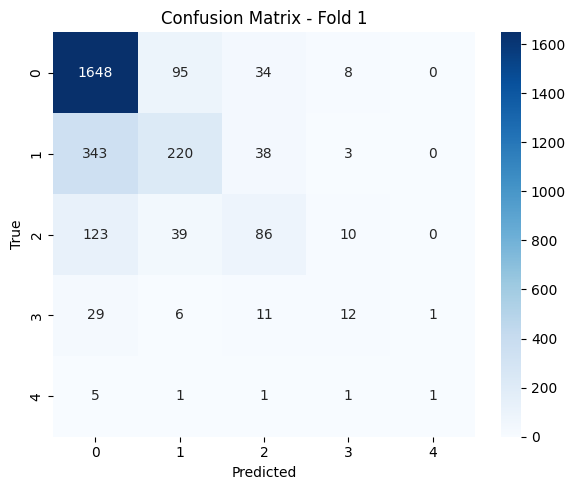

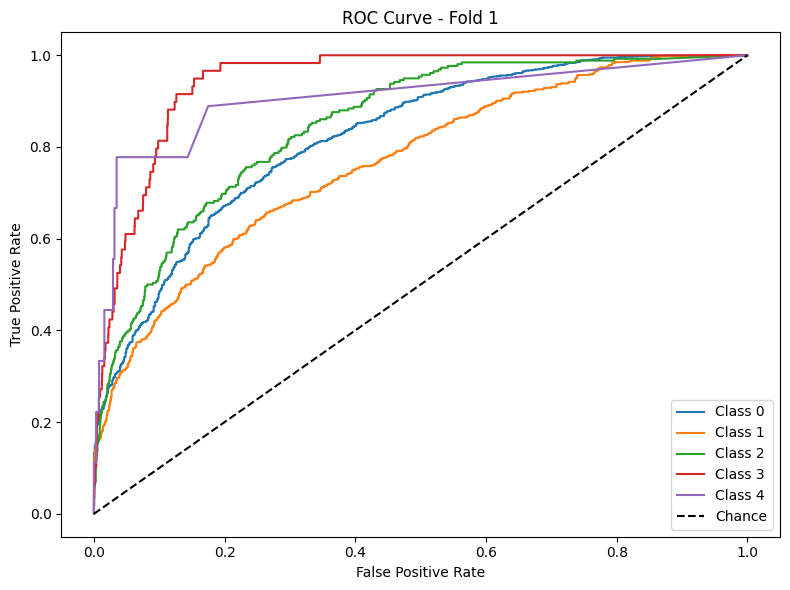


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1786
           1       0.58      0.35      0.43       603
           2       0.50      0.36      0.42       258
           3       0.32      0.19      0.24        59
           4       0.00      0.00      0.00         8

    accuracy                           0.71      2714
   macro avg       0.43      0.36      0.38      2714
weighted avg       0.68      0.71      0.69      2714



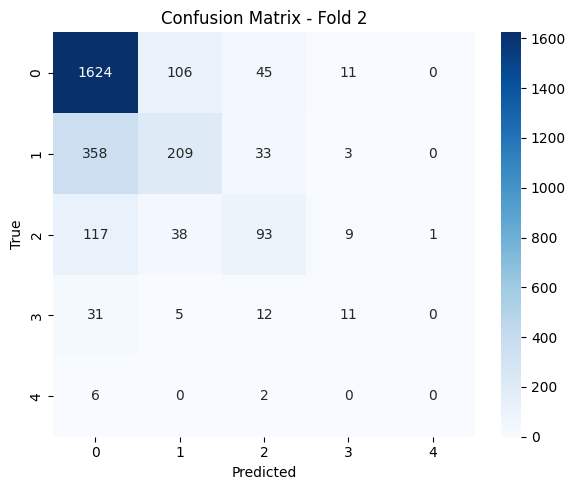

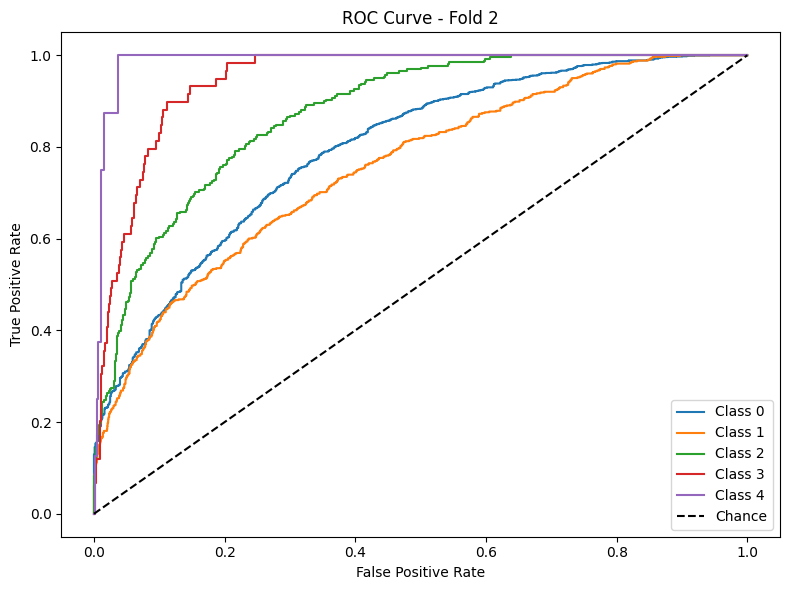


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83      1786
           1       0.61      0.37      0.46       603
           2       0.51      0.34      0.40       258
           3       0.42      0.17      0.24        59
           4       1.00      0.12      0.22         8

    accuracy                           0.72      2714
   macro avg       0.66      0.38      0.43      2714
weighted avg       0.70      0.72      0.69      2714



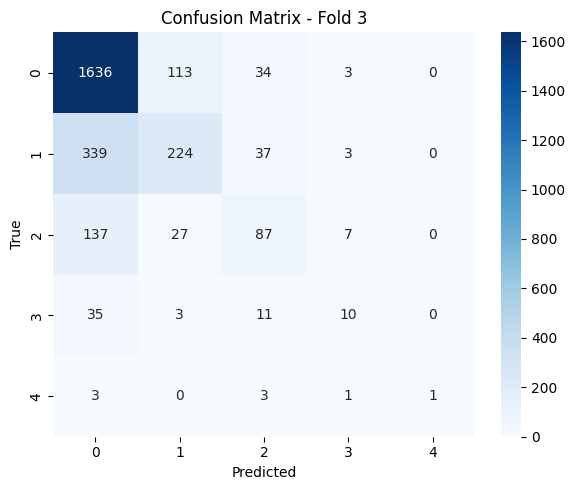

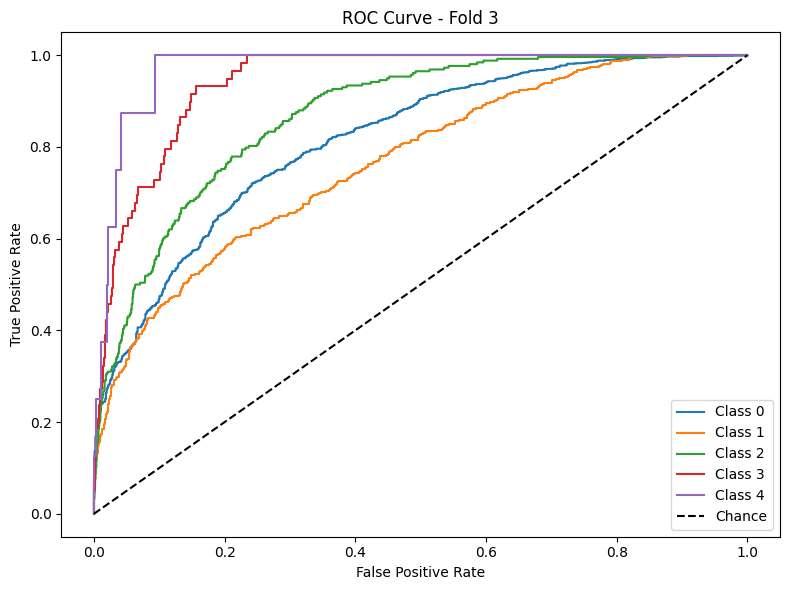

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.84      1785
           1       0.61      0.40      0.48       603
           2       0.57      0.40      0.47       258
           3       0.25      0.10      0.14        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.44      0.36      0.39      2714
weighted avg       0.70      0.73      0.70      2714



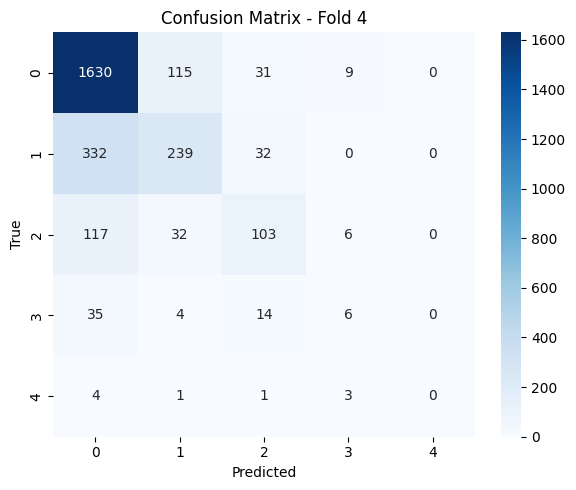

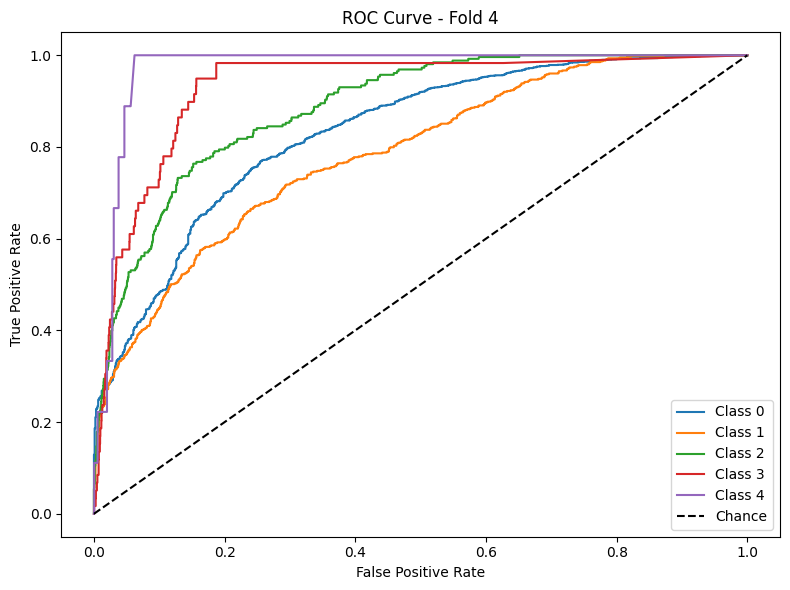

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1785
           1       0.61      0.34      0.44       603
           2       0.53      0.35      0.42       258
           3       0.45      0.17      0.25        59
           4       0.00      0.00      0.00         9

    accuracy                           0.73      2714
   macro avg       0.47      0.36      0.39      2714
weighted avg       0.70      0.73      0.69      2714



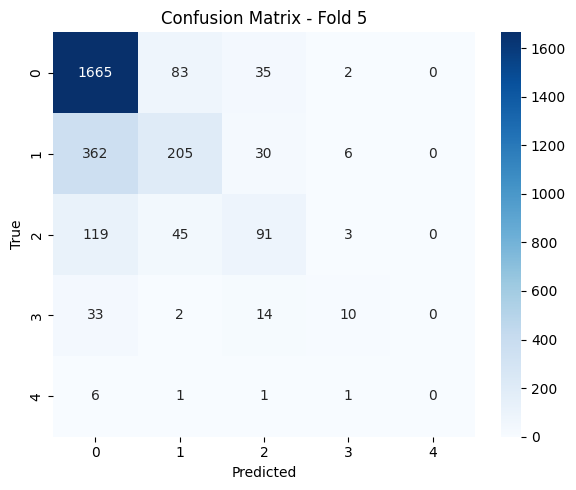

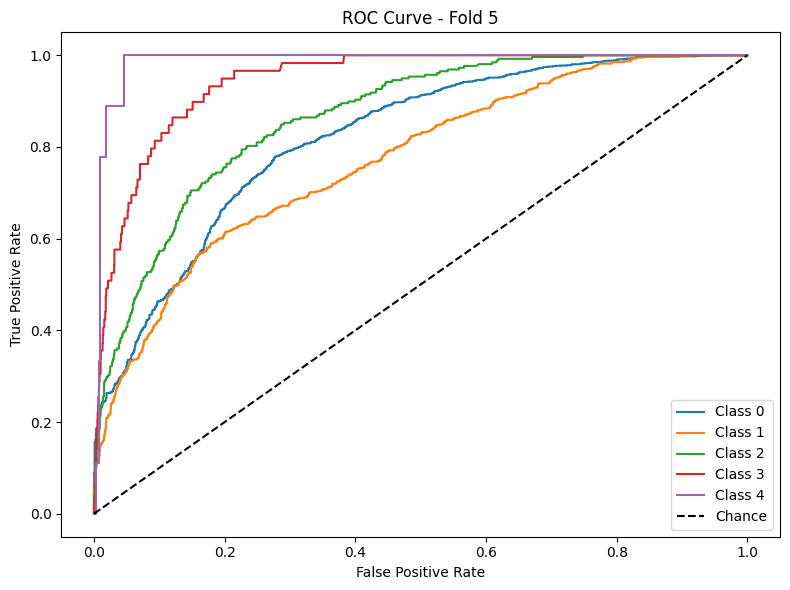


Average Accuracy: 0.7229
Average F1 Macro: 0.4037
Average AUC: 0.8722

Feature Importances:
combined_emb_5                         0.050732
combined_emb_3                         0.047598
combined_emb_12                        0.047072
combined_emb_10                        0.046451
combined_emb_2                         0.043918
combined_emb_1                         0.043912
combined_emb_9                         0.043502
combined_emb_4                         0.042949
combined_emb_0                         0.041809
combined_emb_14                        0.041180
combined_emb_13                        0.041130
combined_emb_11                        0.040720
combined_emb_15                        0.040392
combined_emb_7                         0.040215
combined_emb_6                         0.039034
combined_emb_8                         0.038643
remaining_time                         0.034080
exercise_correct_sum_1                 0.028533
video                                  0.02

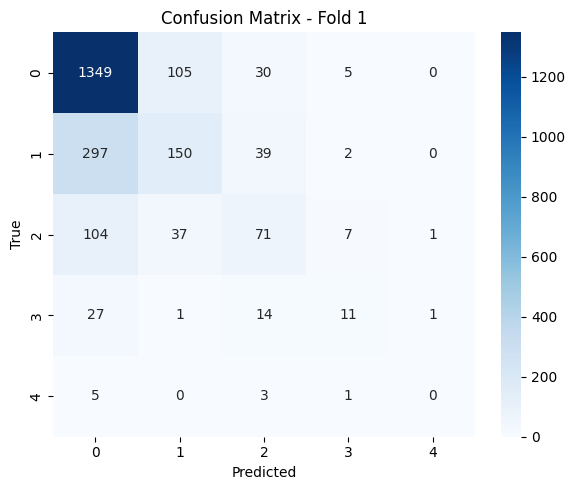

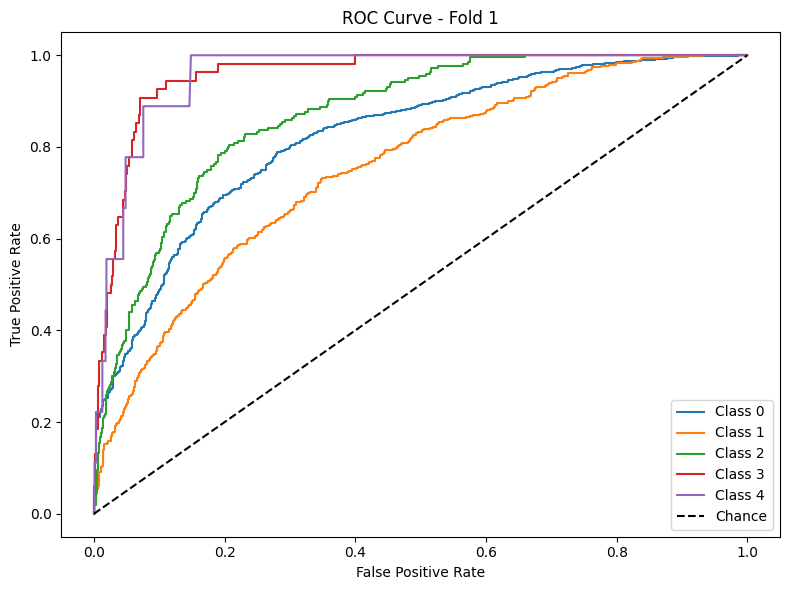

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1489
           1       0.53      0.33      0.41       489
           2       0.49      0.30      0.37       219
           3       0.27      0.20      0.23        55
           4       0.00      0.00      0.00         8

    accuracy                           0.70      2260
   macro avg       0.41      0.35      0.37      2260
weighted avg       0.67      0.70      0.67      2260



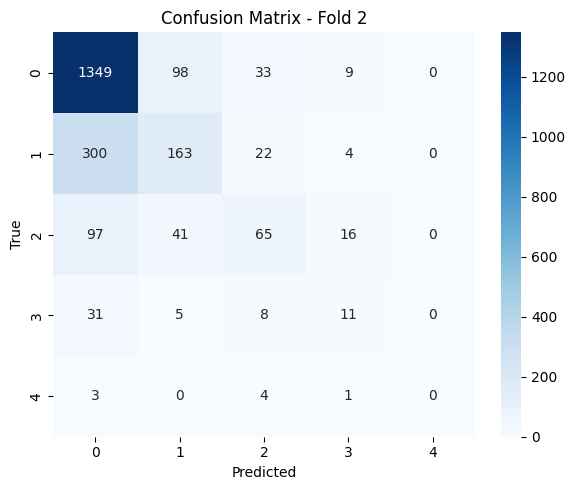

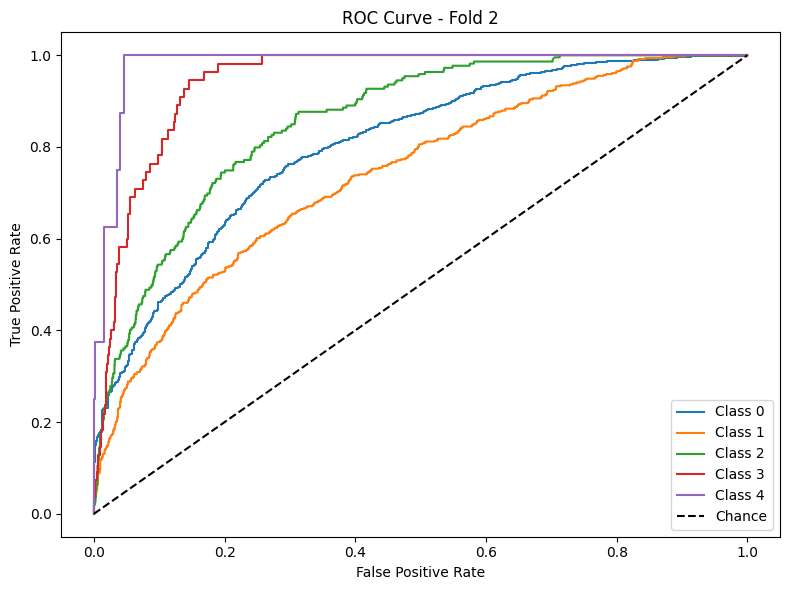


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1489
           1       0.51      0.28      0.36       489
           2       0.49      0.35      0.41       219
           3       0.22      0.15      0.18        54
           4       0.50      0.12      0.20         8

    accuracy                           0.70      2259
   macro avg       0.49      0.36      0.39      2259
weighted avg       0.66      0.70      0.67      2259



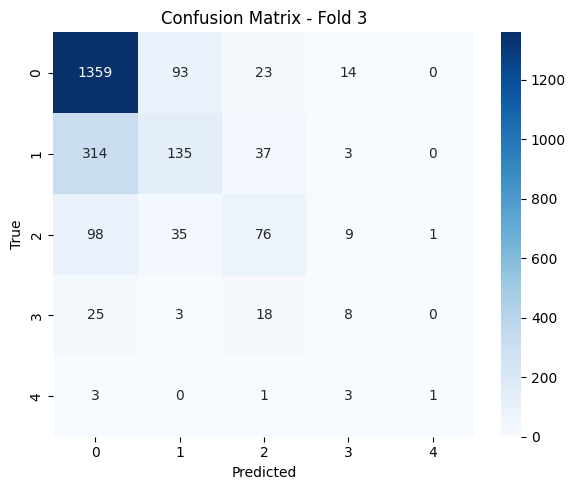

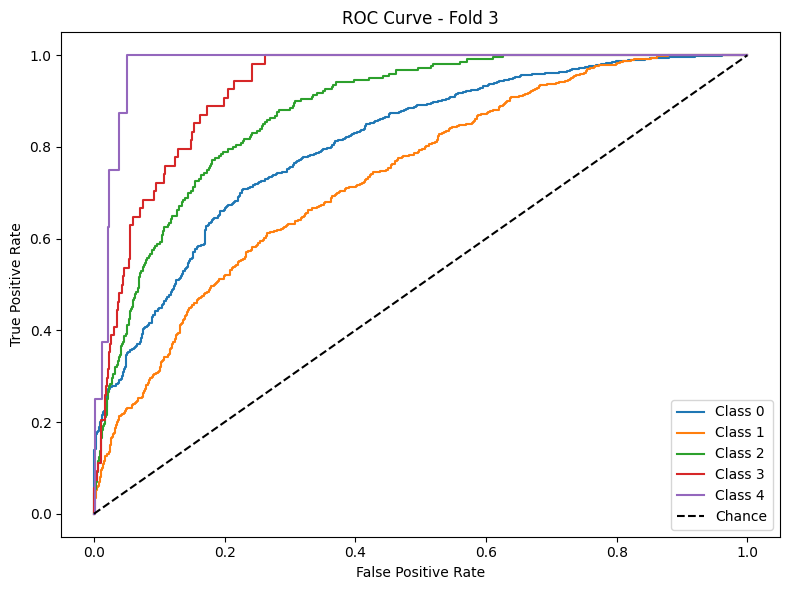


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1489
           1       0.53      0.32      0.40       489
           2       0.47      0.31      0.37       219
           3       0.36      0.19      0.24        54
           4       1.00      0.25      0.40         8

    accuracy                           0.71      2259
   macro avg       0.62      0.39      0.45      2259
weighted avg       0.67      0.71      0.67      2259



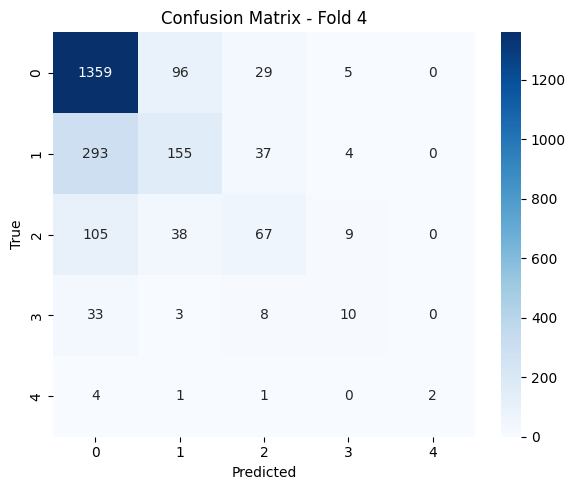

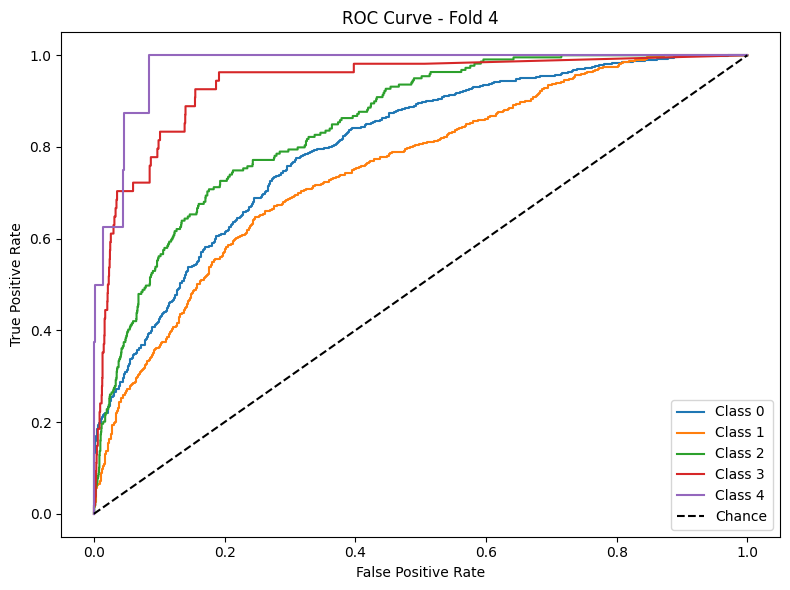


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1490
           1       0.56      0.35      0.43       488
           2       0.47      0.37      0.41       219
           3       0.07      0.02      0.03        54
           4       0.25      0.12      0.17         8

    accuracy                           0.72      2259
   macro avg       0.42      0.36      0.37      2259
weighted avg       0.68      0.72      0.69      2259



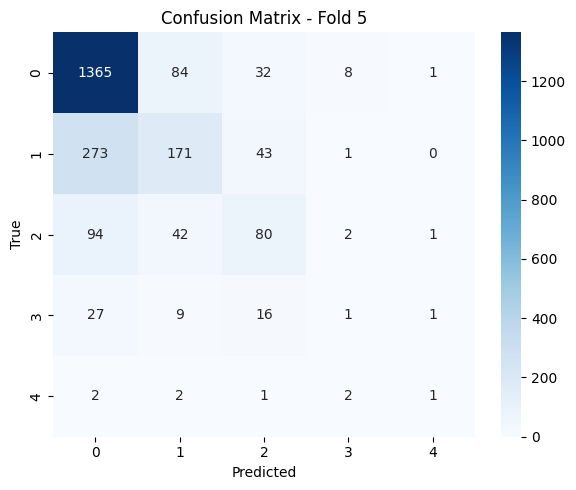

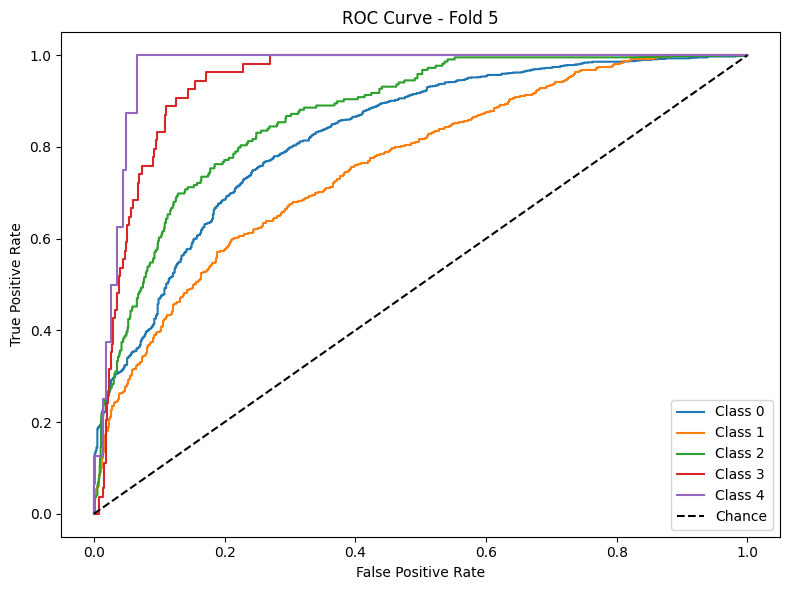


Average Accuracy: 0.7045
Average F1 Macro: 0.3910
Average AUC: 0.8679

Feature Importances:
combined_emb_9                         0.052944
combined_emb_11                        0.052030
combined_emb_10                        0.050063
combined_emb_14                        0.048170
combined_emb_5                         0.047895
combined_emb_6                         0.047852
combined_emb_3                         0.047730
combined_emb_4                         0.047107
combined_emb_13                        0.046099
combined_emb_2                         0.045753
combined_emb_0                         0.045384
combined_emb_15                        0.045360
combined_emb_12                        0.044763
combined_emb_7                         0.044449
combined_emb_8                         0.043976
combined_emb_1                         0.043375
remaining_time                         0.029838
school                                 0.017524
video                                  0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1361
           1       0.57      0.32      0.41       459
           2       0.43      0.34      0.38       198
           3       0.23      0.18      0.20        49
           4       0.00      0.00      0.00         7

    accuracy                           0.71      2074
   macro avg       0.40      0.35      0.36      2074
weighted avg       0.68      0.71      0.68      2074



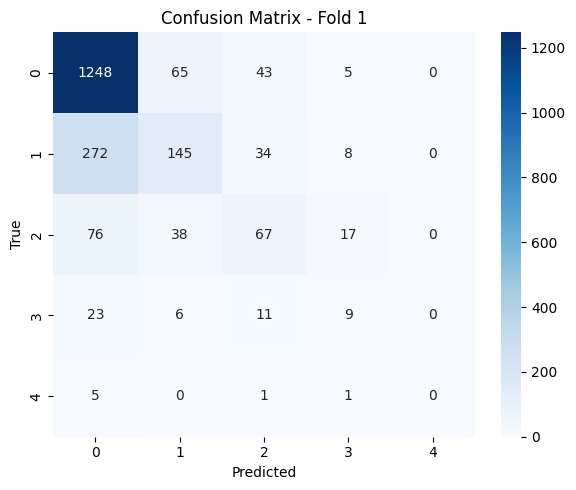

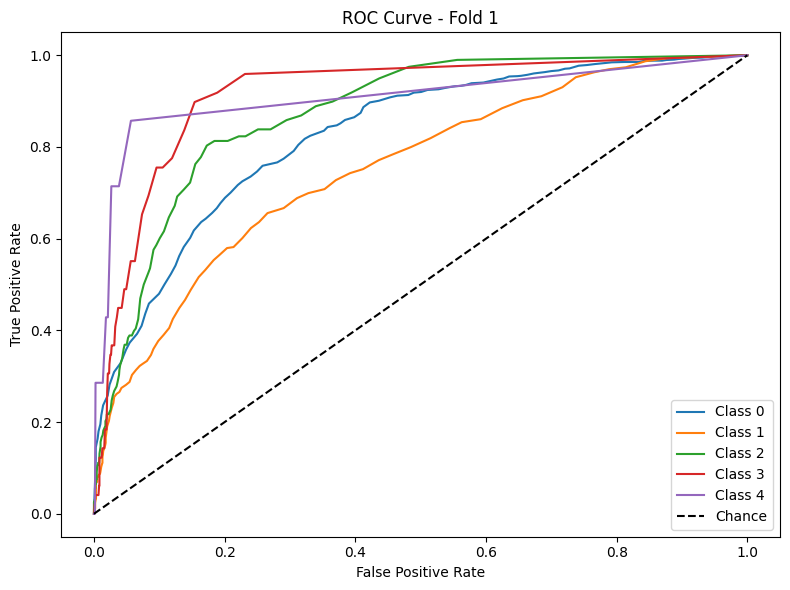


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1360
           1       0.50      0.33      0.40       459
           2       0.48      0.35      0.41       198
           3       0.37      0.22      0.27        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.42      0.36      0.38      2074
weighted avg       0.67      0.70      0.68      2074



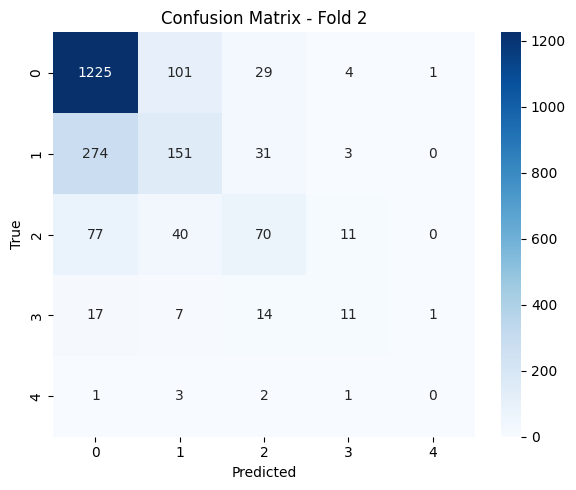

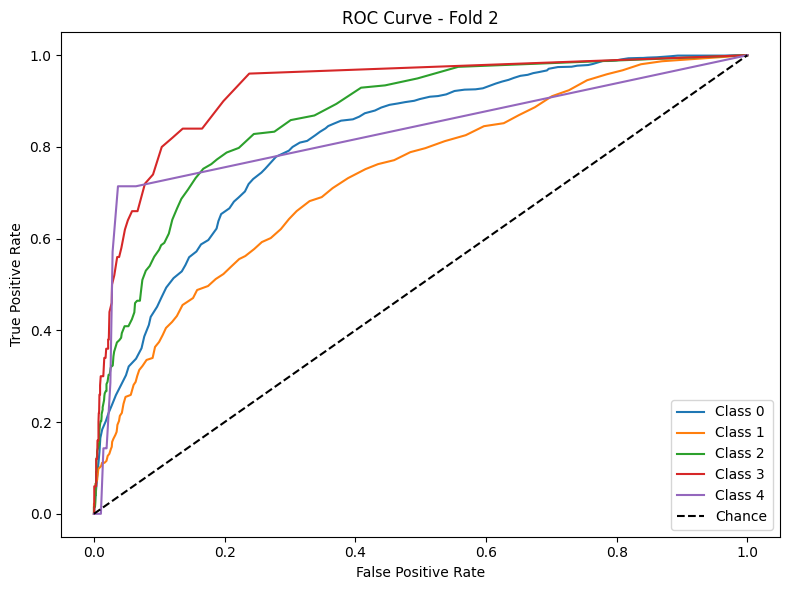


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84      1360
           1       0.49      0.34      0.40       459
           2       0.43      0.35      0.38       198
           3       0.40      0.28      0.33        50
           4       0.00      0.00      0.00         7

    accuracy                           0.70      2074
   macro avg       0.42      0.37      0.39      2074
weighted avg       0.67      0.70      0.68      2074



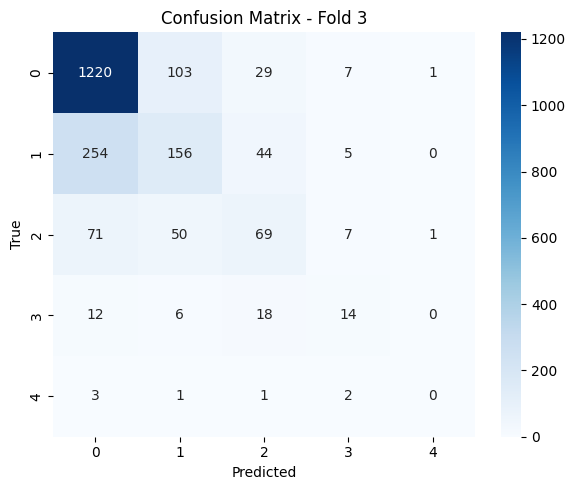

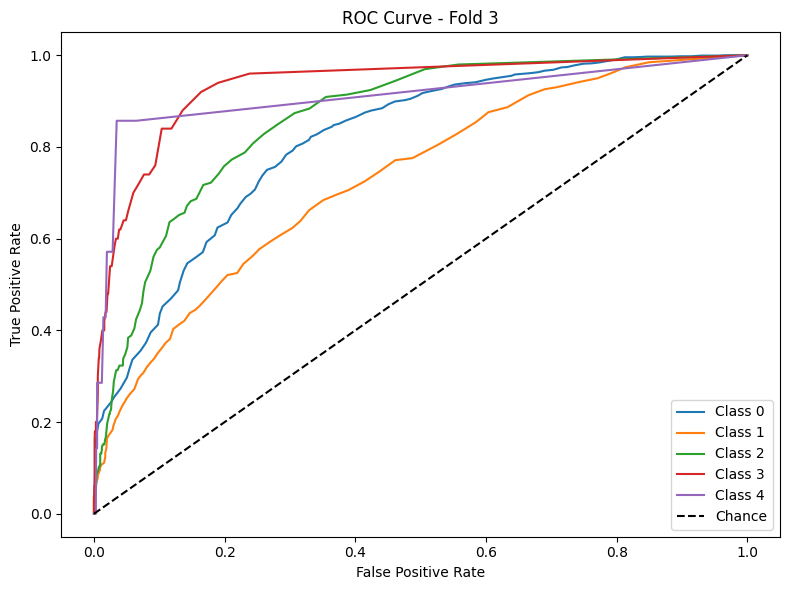

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1360
           1       0.46      0.33      0.39       459
           2       0.49      0.31      0.38       198
           3       0.36      0.24      0.29        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.41      0.35      0.37      2074
weighted avg       0.65      0.69      0.66      2074



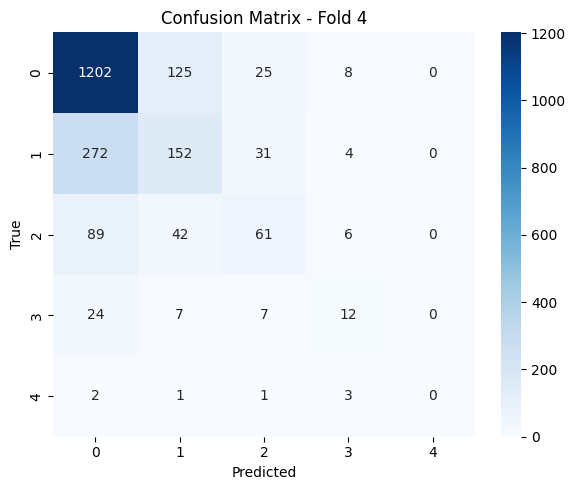

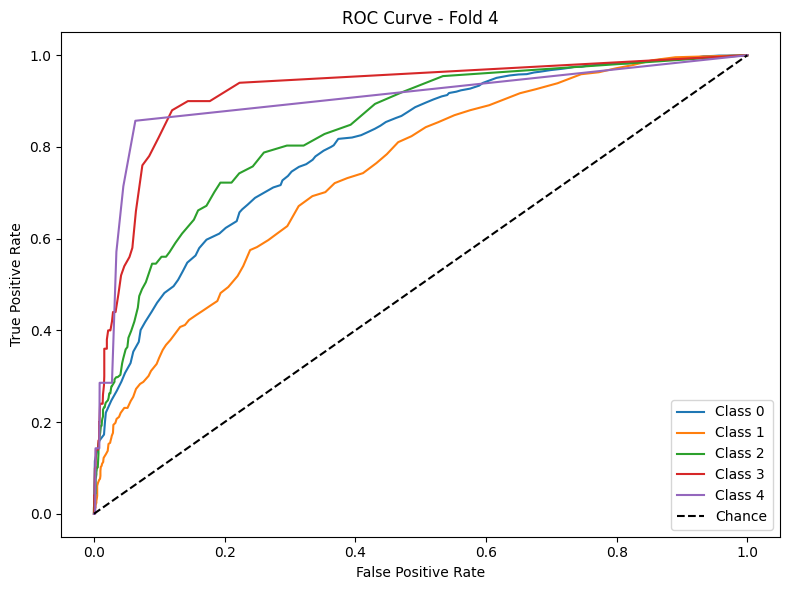

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82      1360
           1       0.49      0.33      0.40       460
           2       0.45      0.36      0.40       197
           3       0.30      0.20      0.24        49
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2073
   macro avg       0.40      0.36      0.37      2073
weighted avg       0.66      0.69      0.67      2073



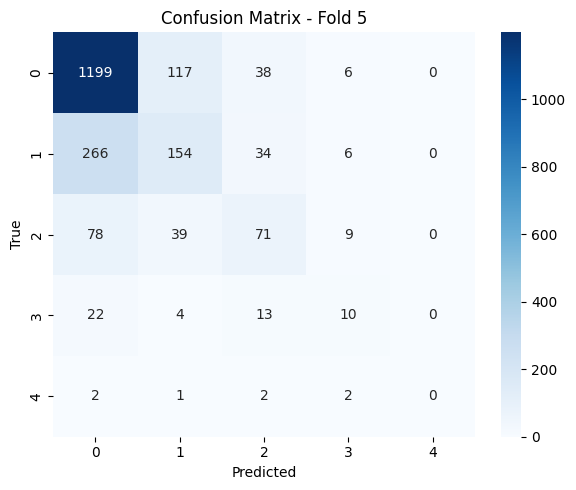

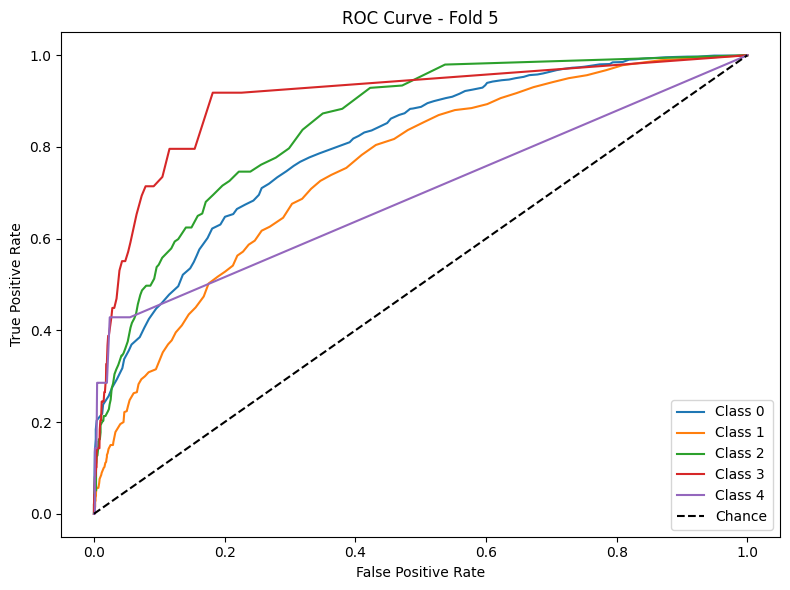


Average Accuracy: 0.6988
Average F1 Macro: 0.3765
Average AUC: 0.8360

Feature Importances:
combined_emb_12                        0.050882
combined_emb_0                         0.049961
combined_emb_15                        0.049951
combined_emb_8                         0.049279
combined_emb_1                         0.048962
combined_emb_2                         0.048111
combined_emb_6                         0.047828
combined_emb_7                         0.047632
combined_emb_3                         0.046446
combined_emb_10                        0.046269
combined_emb_11                        0.045585
combined_emb_4                         0.045565
combined_emb_14                        0.045419
combined_emb_13                        0.045155
combined_emb_5                         0.045036
combined_emb_9                         0.043914
remaining_time                         0.031178
school                                 0.014729
total_words_phase1                     0.01

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84      1000
           1       0.62      0.39      0.48       355
           2       0.41      0.29      0.34       139
           3       0.48      0.36      0.41        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1539
   macro avg       0.46      0.39      0.41      1539
weighted avg       0.70      0.72      0.70      1539



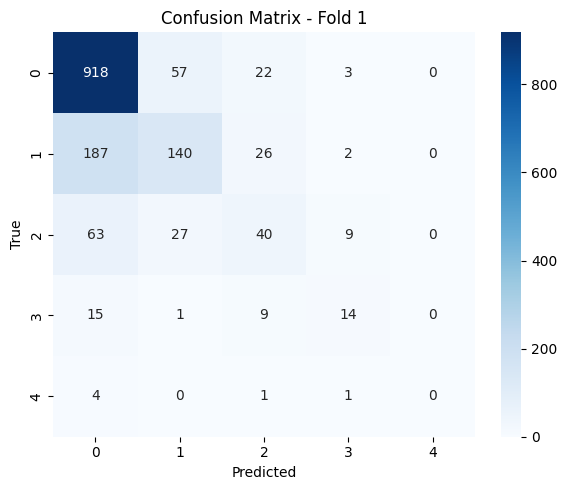

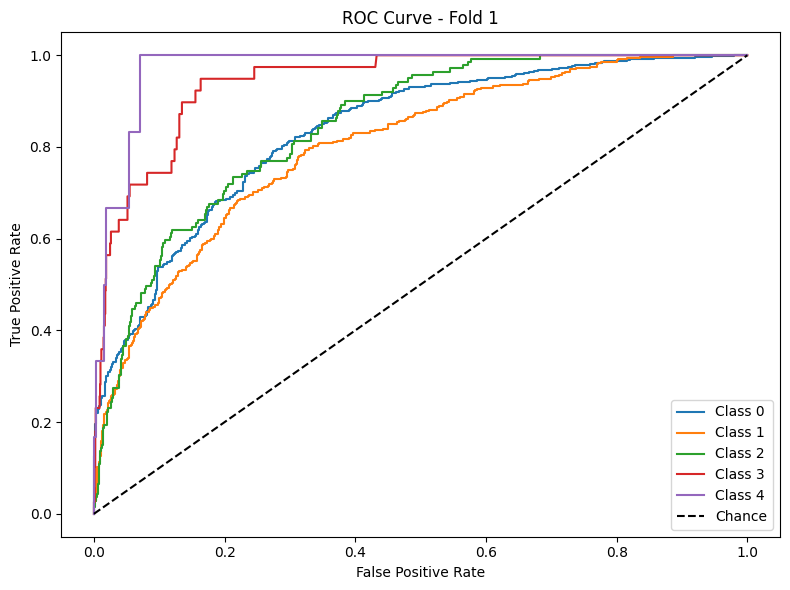


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1000
           1       0.57      0.37      0.45       355
           2       0.60      0.40      0.48       139
           3       0.44      0.38      0.41        40
           4       0.00      0.00      0.00         5

    accuracy                           0.73      1539
   macro avg       0.48      0.41      0.43      1539
weighted avg       0.70      0.73      0.70      1539



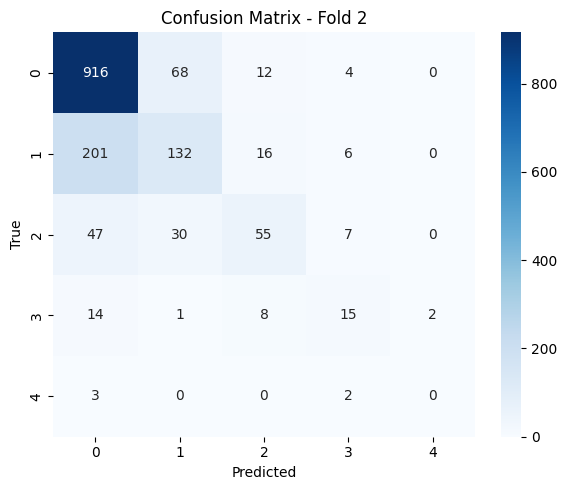

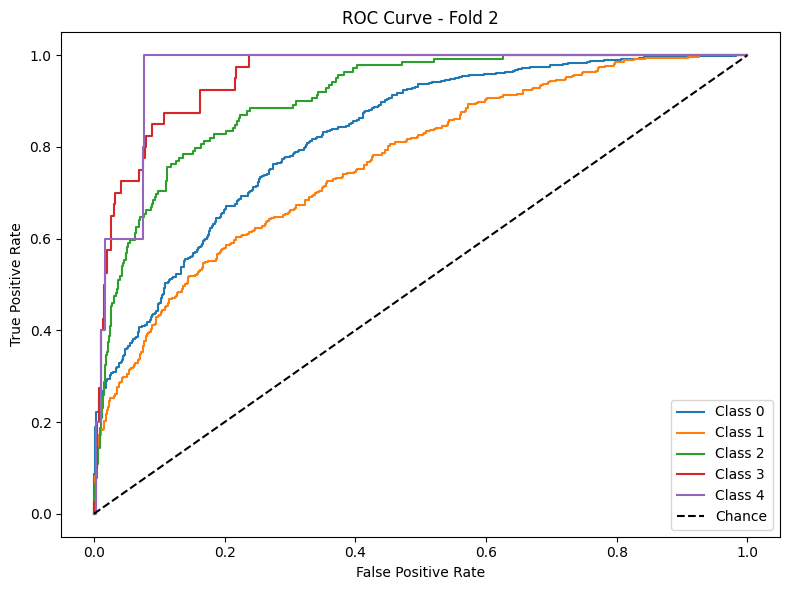


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.85       999
           1       0.62      0.41      0.50       355
           2       0.58      0.35      0.44       139
           3       0.44      0.40      0.42        40
           4       0.00      0.00      0.00         6

    accuracy                           0.74      1539
   macro avg       0.49      0.42      0.44      1539
weighted avg       0.72      0.74      0.72      1539



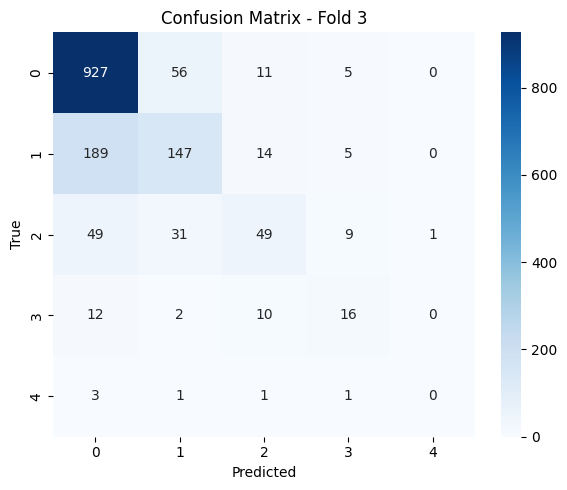

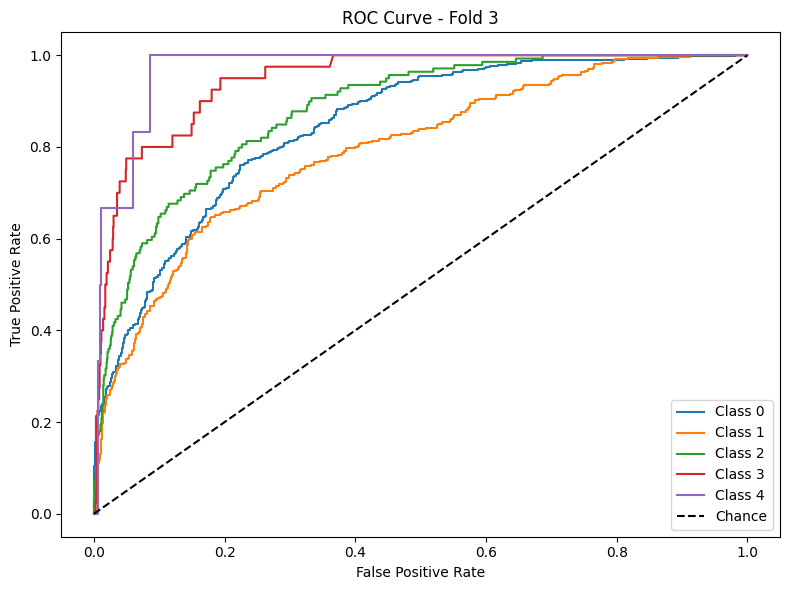

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85       999
           1       0.57      0.34      0.43       356
           2       0.50      0.40      0.45       138
           3       0.32      0.23      0.27        39
           4       0.00      0.00      0.00         6

    accuracy                           0.72      1538
   macro avg       0.44      0.38      0.40      1538
weighted avg       0.69      0.72      0.70      1538



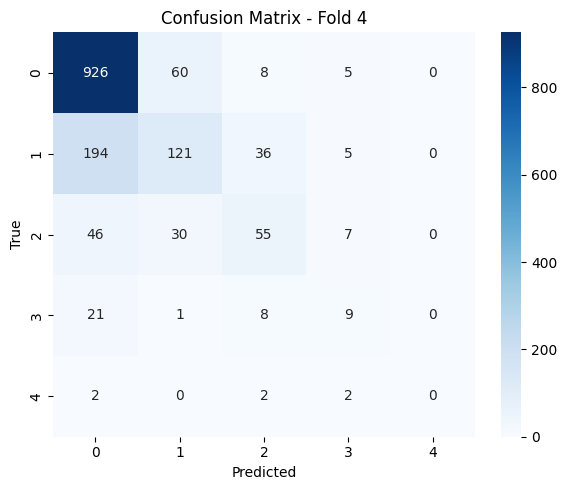

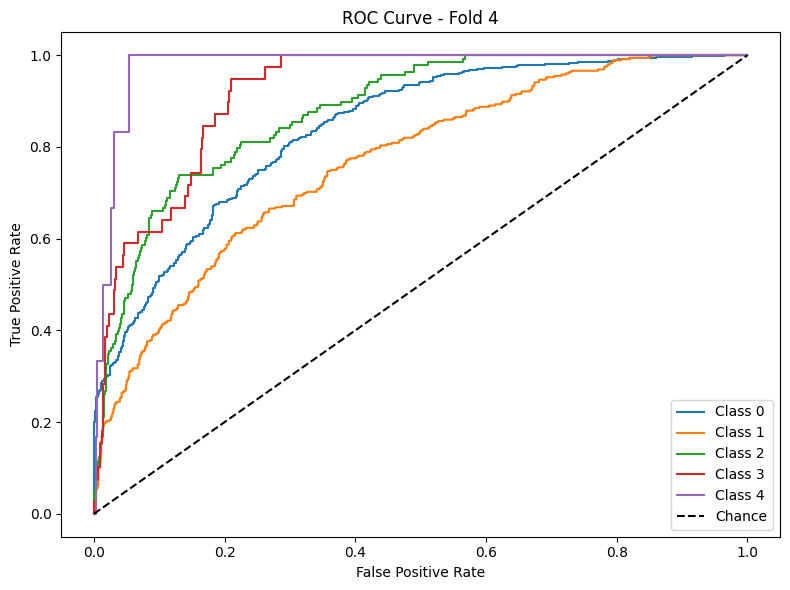


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       999
           1       0.54      0.37      0.44       356
           2       0.44      0.32      0.37       138
           3       0.47      0.51      0.49        39
           4       0.00      0.00      0.00         6

    accuracy                           0.71      1538
   macro avg       0.45      0.42      0.43      1538
weighted avg       0.69      0.71      0.69      1538



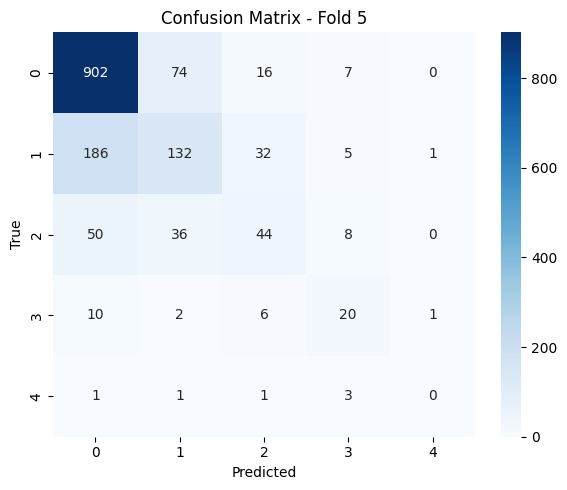

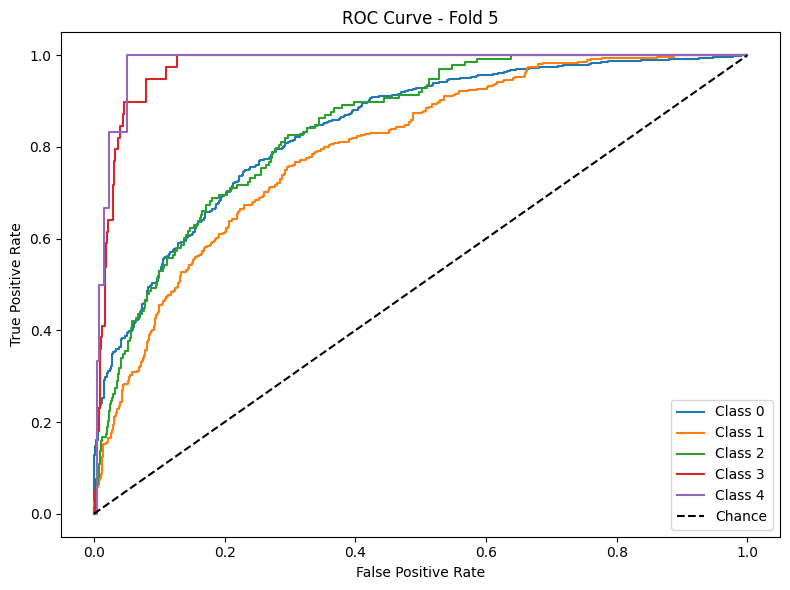


Average Accuracy: 0.7251
Average F1 Macro: 0.4231
Average AUC: 0.8827

Feature Importances:
combined_emb_1                         5.740595e-02
combined_emb_13                        4.323091e-02
combined_emb_7                         4.105447e-02
combined_emb_0                         4.024742e-02
combined_emb_4                         3.991321e-02
combined_emb_10                        3.952016e-02
combined_emb_11                        3.949206e-02
combined_emb_14                        3.765935e-02
combined_emb_15                        3.708819e-02
combined_emb_2                         3.697707e-02
combined_emb_8                         3.563054e-02
combined_emb_9                         3.559489e-02
combined_emb_5                         3.553062e-02
combined_emb_12                        3.500672e-02
combined_emb_6                         3.500290e-02
combined_emb_3                         3.447236e-02
school                                 2.497734e-02
remaining_time         

In [5]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n================================================")
    print(f"\n============== Training Phase {i} ===============")
    print(f"\n=================================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       568
           1       0.42      0.08      0.13        63
           2       0.32      0.14      0.19        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.82       698
   macro avg       0.31      0.24      0.25       698
weighted avg       0.74      0.82      0.76       698



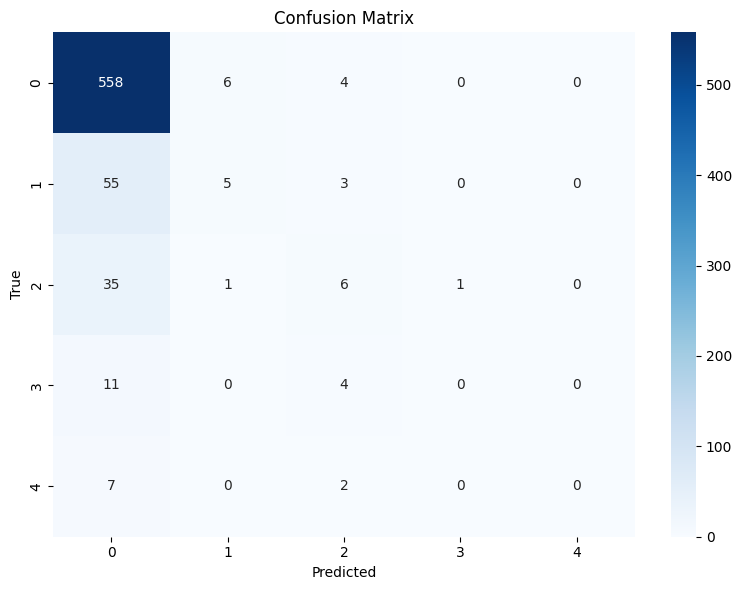


Test AUC (macro-average, OVR): 0.8044


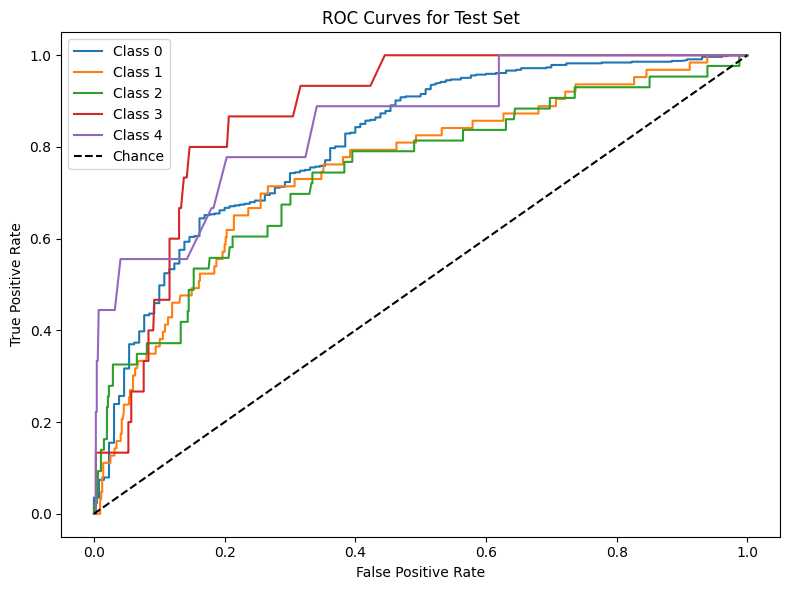

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       544
           1       0.12      0.02      0.03        59
           2       0.17      0.02      0.04        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.22      0.20      0.19       668
weighted avg       0.69      0.80      0.73       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


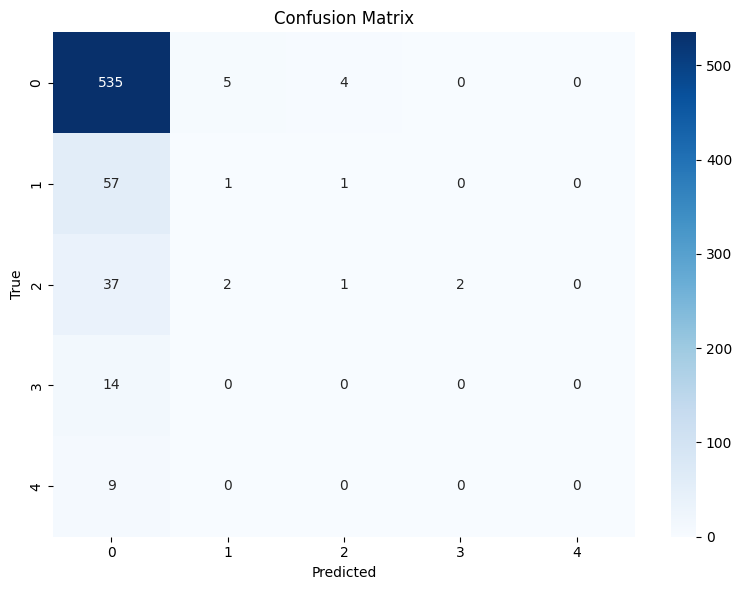


Test AUC (macro-average, OVR): 0.8098


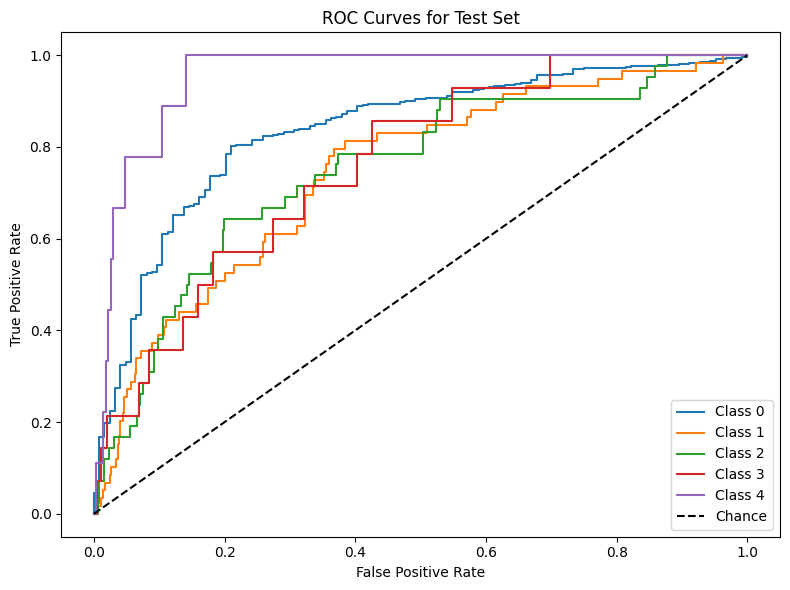

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       455
           1       0.29      0.04      0.07        52
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       554
   macro avg       0.22      0.21      0.19       554
weighted avg       0.71      0.82      0.75       554



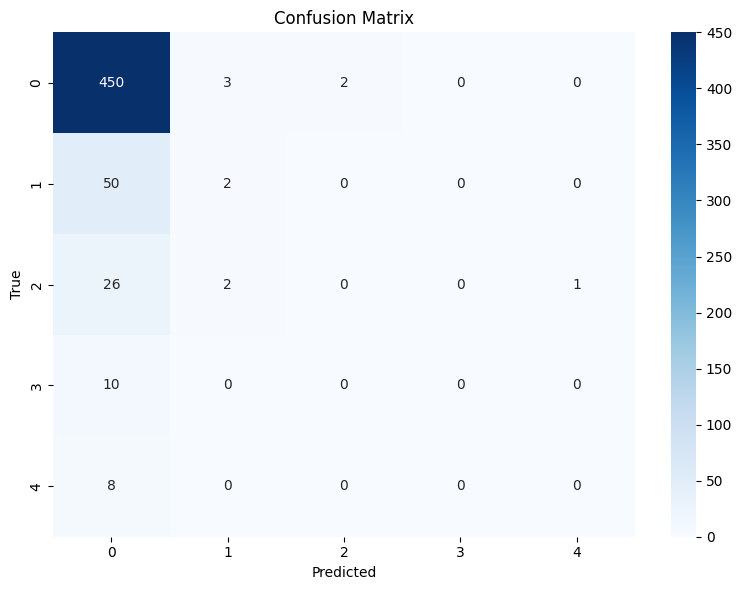


Test AUC (macro-average, OVR): 0.6731


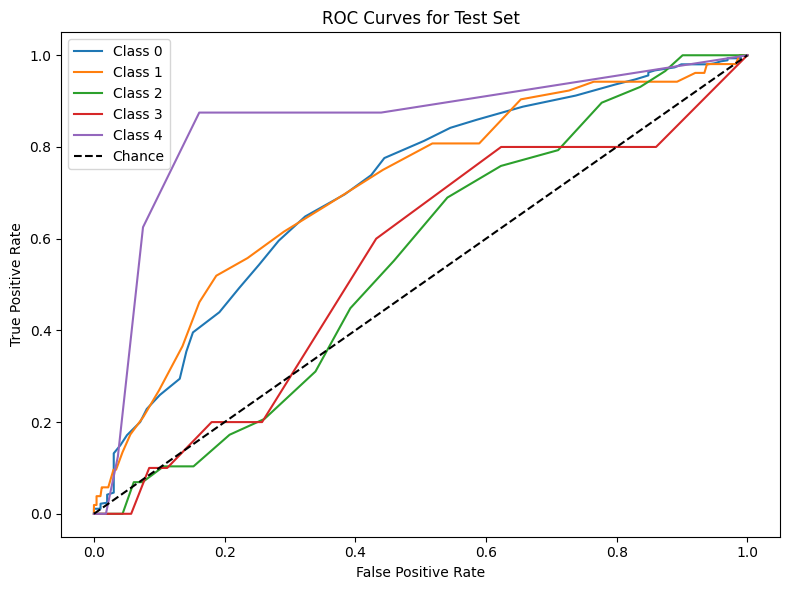

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       395
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.82       477
   macro avg       0.17      0.20      0.18       477
weighted avg       0.68      0.82      0.74       477



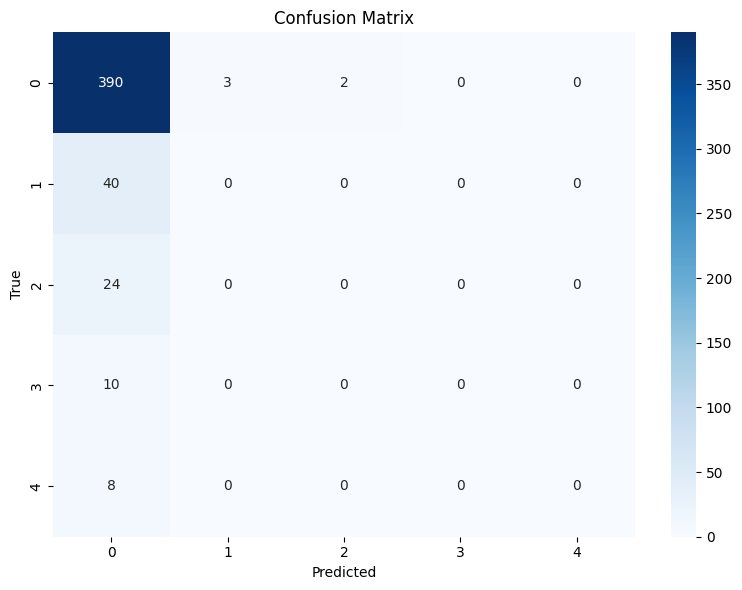


Test AUC (macro-average, OVR): 0.7010


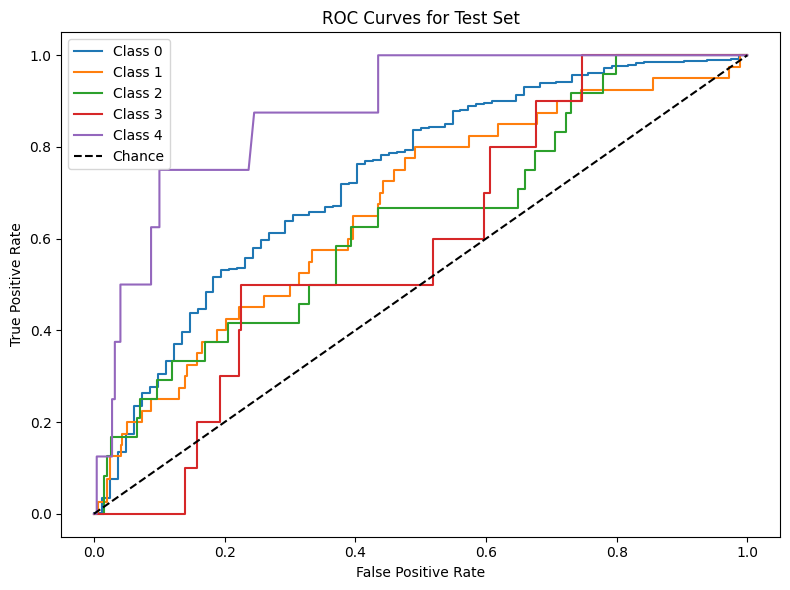

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82      1785
           1       0.54      0.48      0.50       604
           2       0.39      0.44      0.41       258
           3       0.27      0.39      0.32        59
           4       0.33      0.11      0.17         9

    accuracy                           0.70      2715
   macro avg       0.47      0.45      0.44      2715
weighted avg       0.70      0.70      0.70      2715



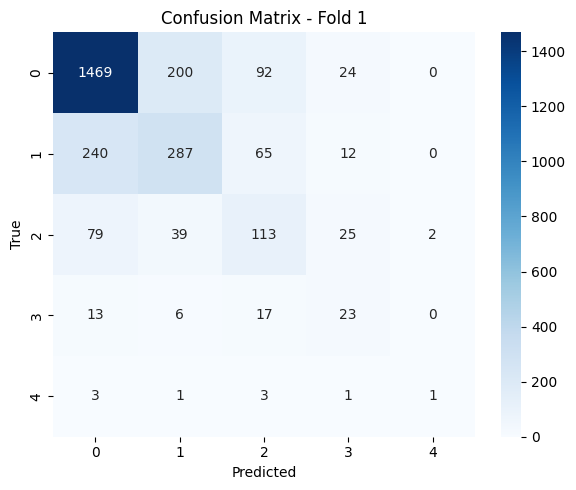

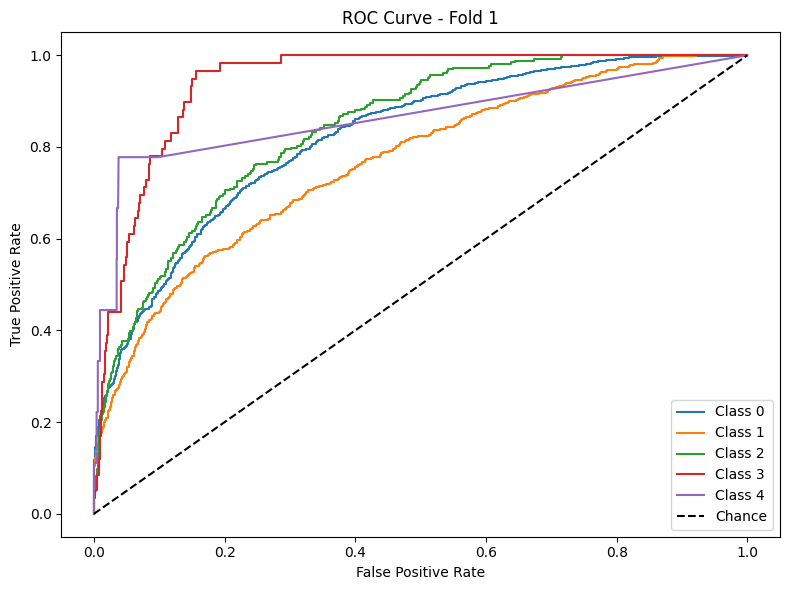


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      1786
           1       0.51      0.44      0.47       603
           2       0.42      0.52      0.46       258
           3       0.26      0.39      0.31        59
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2714
   macro avg       0.40      0.43      0.41      2714
weighted avg       0.69      0.69      0.69      2714



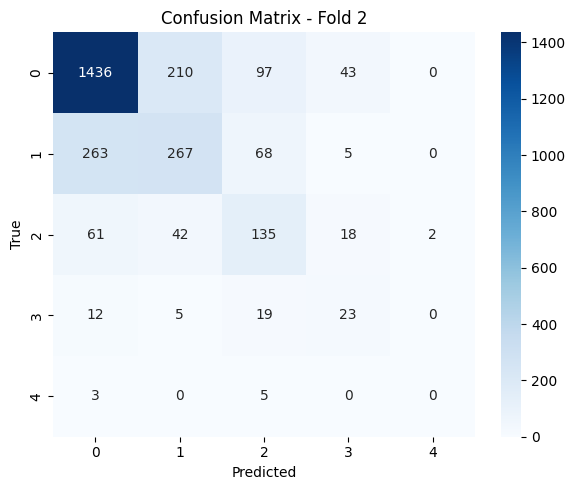

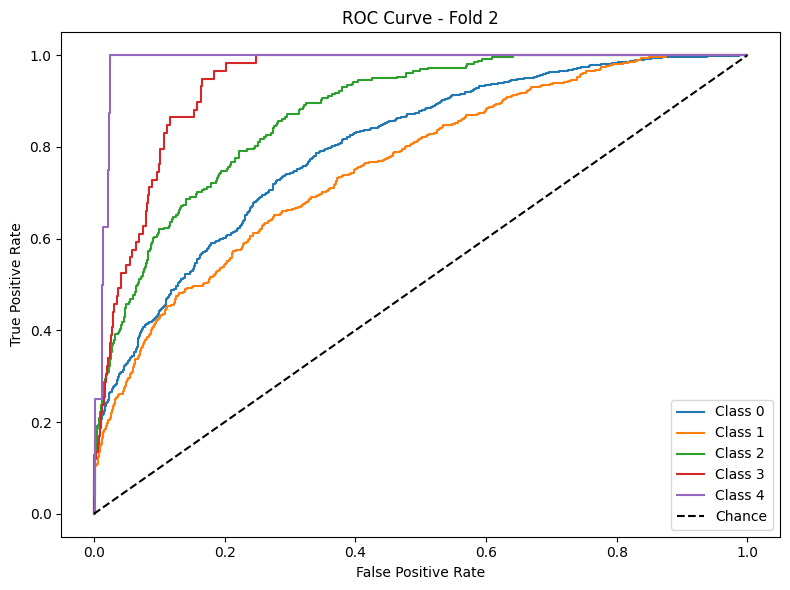


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1786
           1       0.52      0.48      0.50       603
           2       0.43      0.50      0.46       258
           3       0.25      0.31      0.27        59
           4       0.33      0.25      0.29         8

    accuracy                           0.69      2714
   macro avg       0.47      0.47      0.47      2714
weighted avg       0.70      0.69      0.69      2714



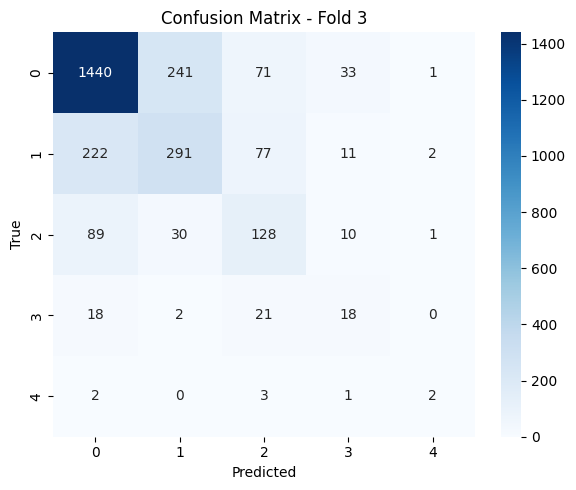

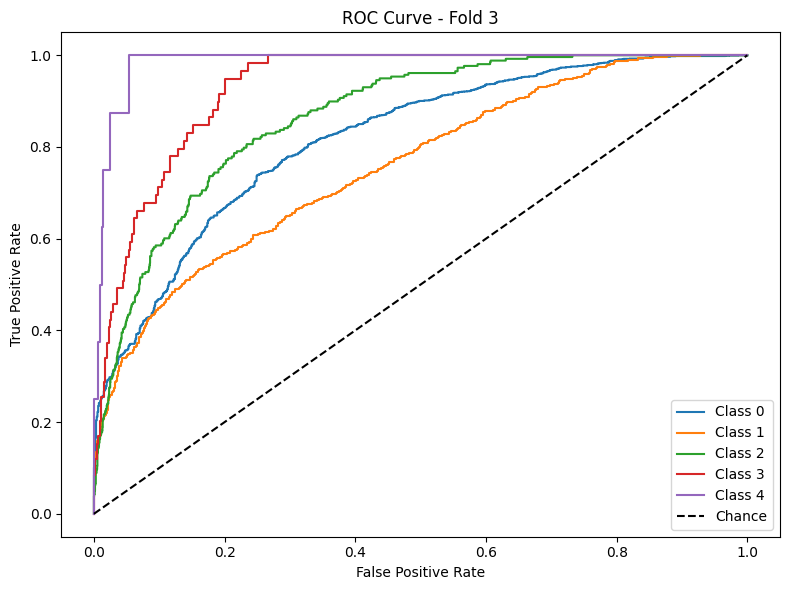


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.82      1785
           1       0.53      0.49      0.51       603
           2       0.46      0.50      0.48       258
           3       0.21      0.25      0.23        59
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2714
   macro avg       0.40      0.41      0.41      2714
weighted avg       0.70      0.70      0.70      2714



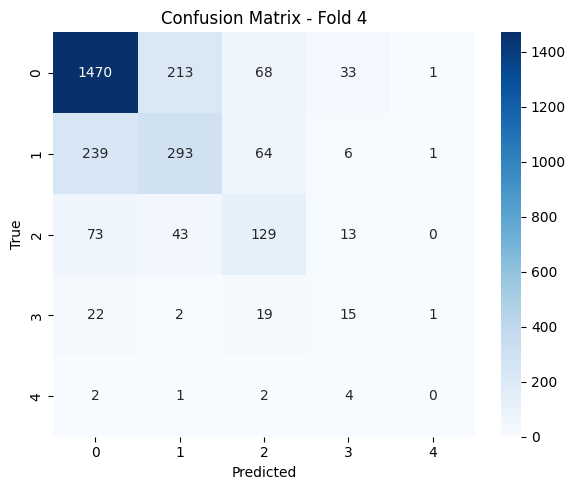

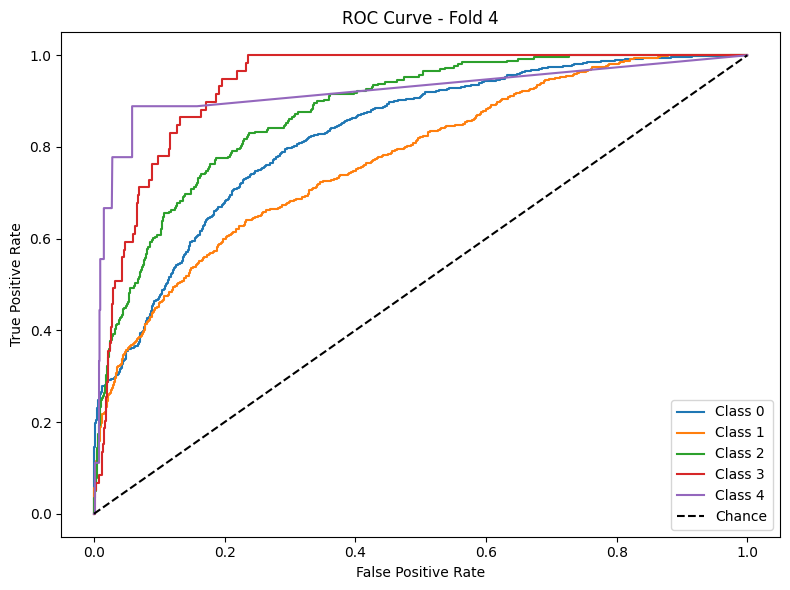


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1785
           1       0.55      0.48      0.51       603
           2       0.41      0.45      0.43       258
           3       0.27      0.37      0.31        59
           4       0.50      0.11      0.18         9

    accuracy                           0.70      2714
   macro avg       0.51      0.45      0.45      2714
weighted avg       0.70      0.70      0.70      2714



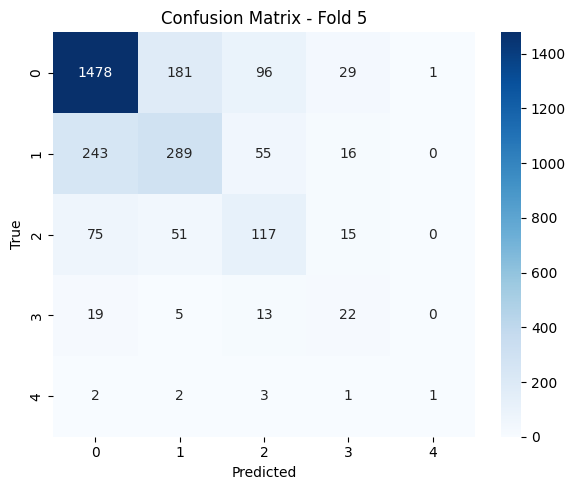

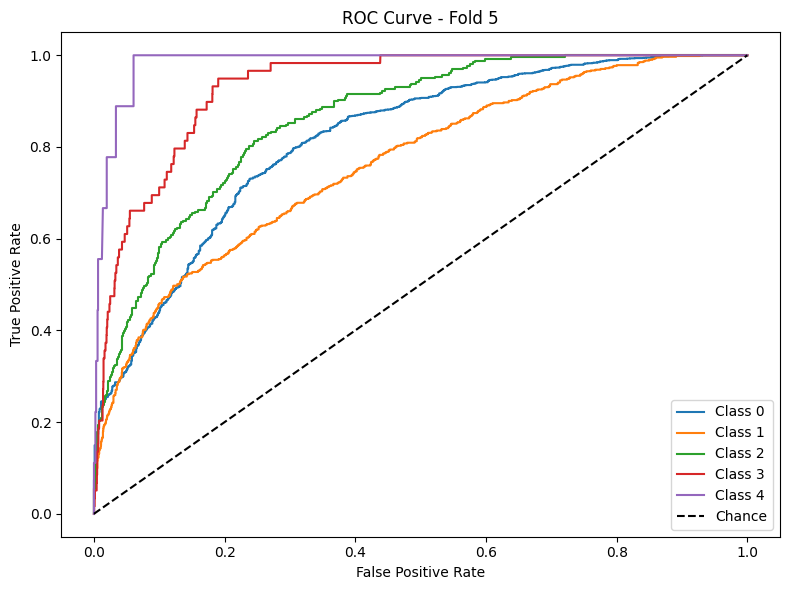


Average Accuracy: 0.6961
Average F1 Macro: 0.4357
Average AUC: 0.8655

Feature Importances:
assignment                             0.058708
video                                  0.055300
combined_emb_2                         0.054353
combined_emb_3                         0.042689
combined_emb_14                        0.041658
combined_emb_10                        0.041322
combined_emb_1                         0.038219
combined_emb_5                         0.037847
combined_emb_13                        0.036569
combined_emb_12                        0.036405
combined_emb_11                        0.035950
combined_emb_0                         0.035328
encoded_field_sum                      0.034670
combined_emb_9                         0.034391
combined_emb_4                         0.032847
remaining_time                         0.031289
combined_emb_15                        0.030776
combined_emb_6                         0.030727
combined_emb_8                         0.02

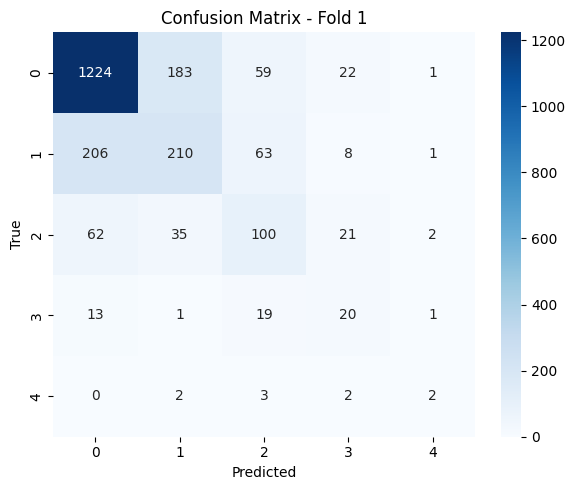

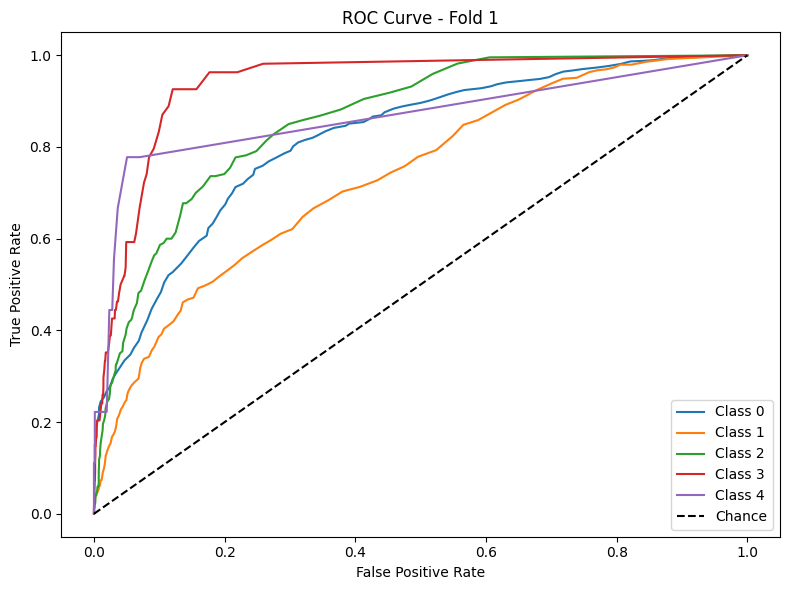


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1489
           1       0.49      0.44      0.46       489
           2       0.37      0.42      0.40       219
           3       0.23      0.36      0.28        55
           4       0.50      0.12      0.20         8

    accuracy                           0.67      2260
   macro avg       0.48      0.43      0.43      2260
weighted avg       0.68      0.67      0.68      2260



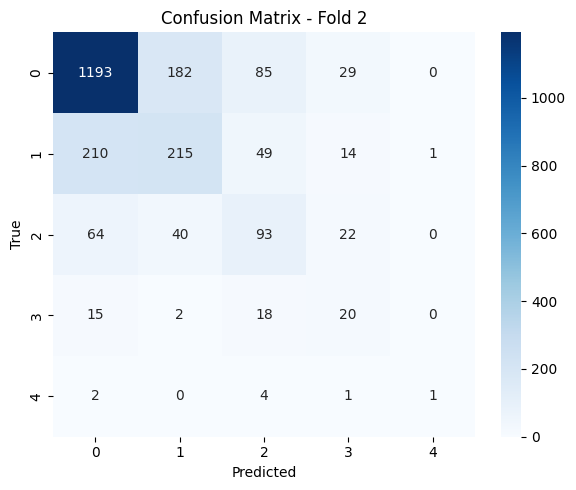

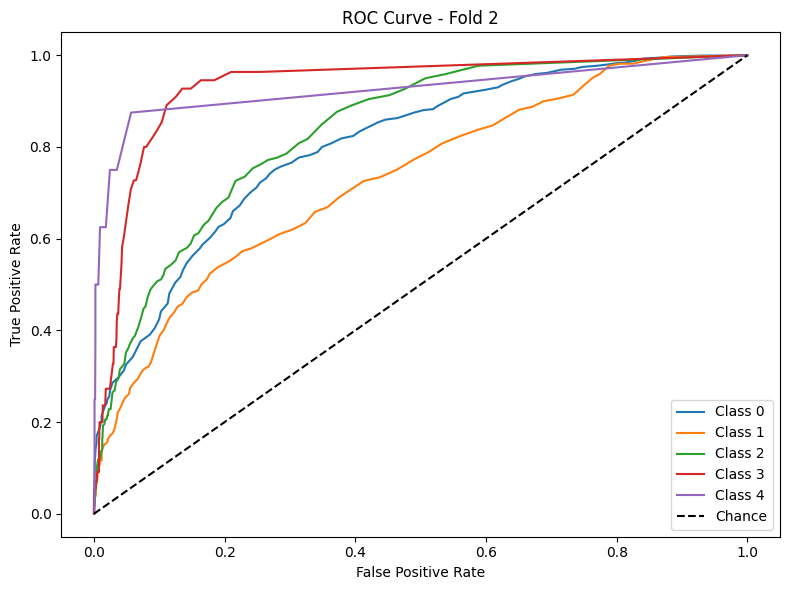


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      1489
           1       0.44      0.39      0.41       489
           2       0.41      0.43      0.42       219
           3       0.22      0.33      0.27        54
           4       0.40      0.25      0.31         8

    accuracy                           0.67      2259
   macro avg       0.45      0.44      0.44      2259
weighted avg       0.67      0.67      0.67      2259



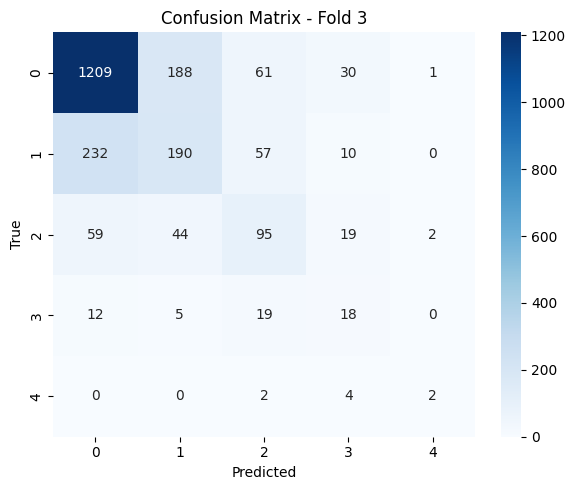

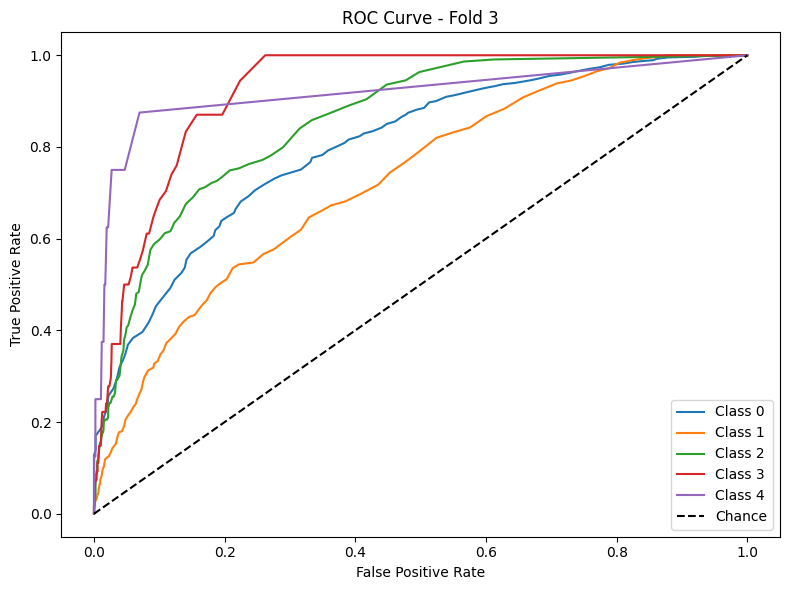


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      1489
           1       0.49      0.44      0.46       489
           2       0.41      0.47      0.44       219
           3       0.30      0.33      0.31        54
           4       0.67      0.50      0.57         8

    accuracy                           0.69      2259
   macro avg       0.53      0.51      0.52      2259
weighted avg       0.69      0.69      0.69      2259



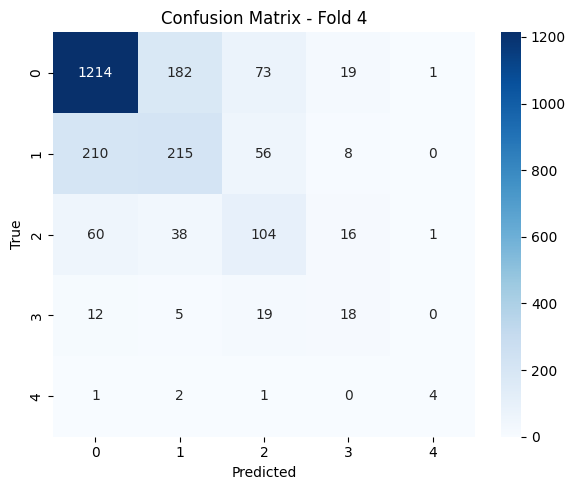

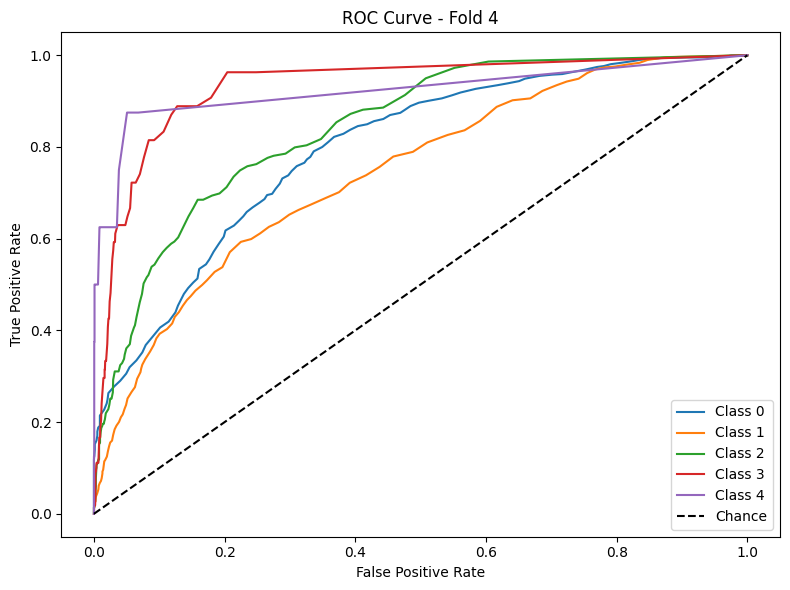


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1490
           1       0.51      0.46      0.48       488
           2       0.39      0.51      0.44       219
           3       0.17      0.13      0.15        54
           4       0.17      0.12      0.14         8

    accuracy                           0.69      2259
   macro avg       0.41      0.41      0.41      2259
weighted avg       0.70      0.69      0.69      2259



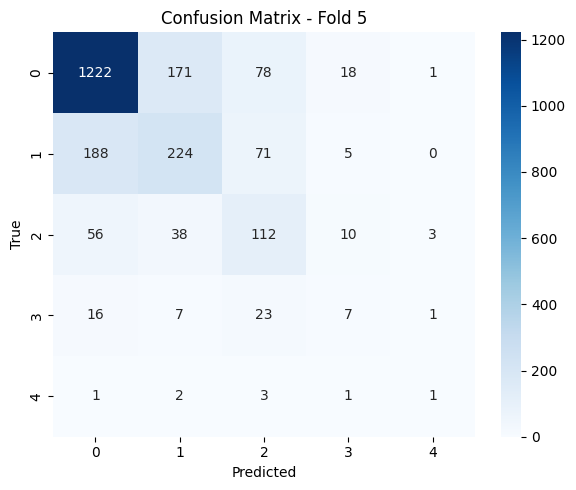

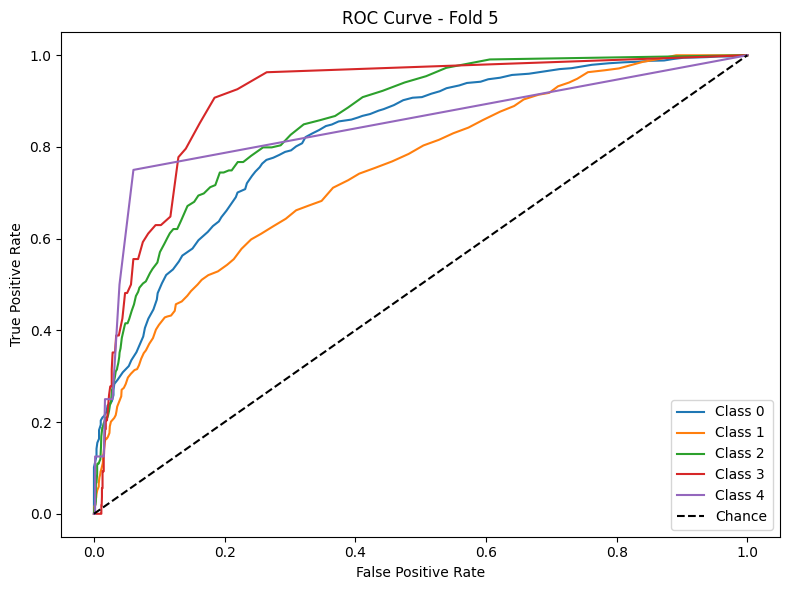


Average Accuracy: 0.6827
Average F1 Macro: 0.4508
Average AUC: 0.8433

Feature Importances:
combined_emb_9                         5.534494e-02
assignment                             4.949077e-02
combined_emb_5                         4.813115e-02
combined_emb_2                         4.364140e-02
combined_emb_7                         4.356803e-02
combined_emb_14                        4.317214e-02
combined_emb_3                         4.119072e-02
combined_emb_8                         4.108607e-02
combined_emb_15                        4.050263e-02
video                                  4.003278e-02
combined_emb_11                        3.880667e-02
combined_emb_13                        3.761611e-02
combined_emb_6                         3.710212e-02
combined_emb_0                         3.585396e-02
user_month                             3.544821e-02
combined_emb_4                         3.527719e-02
combined_emb_12                        3.471009e-02
combined_emb_10        

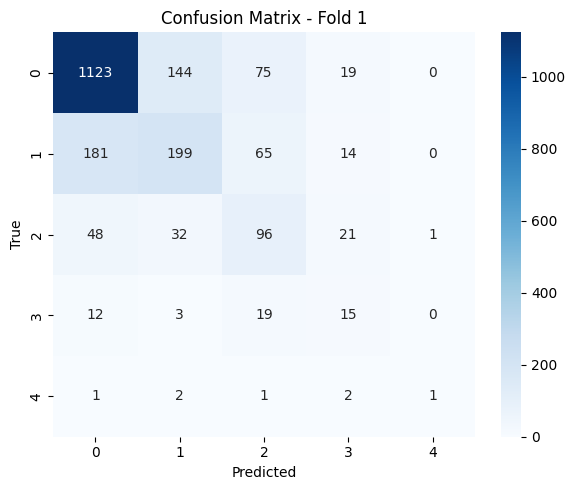

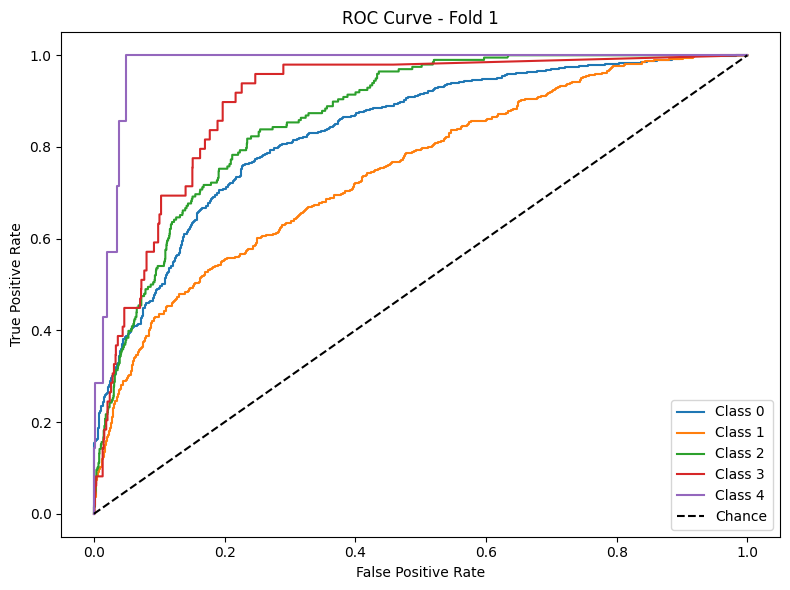


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      1360
           1       0.49      0.44      0.46       459
           2       0.44      0.49      0.46       198
           3       0.39      0.48      0.43        50
           4       0.00      0.00      0.00         7

    accuracy                           0.69      2074
   macro avg       0.43      0.45      0.43      2074
weighted avg       0.69      0.69      0.69      2074



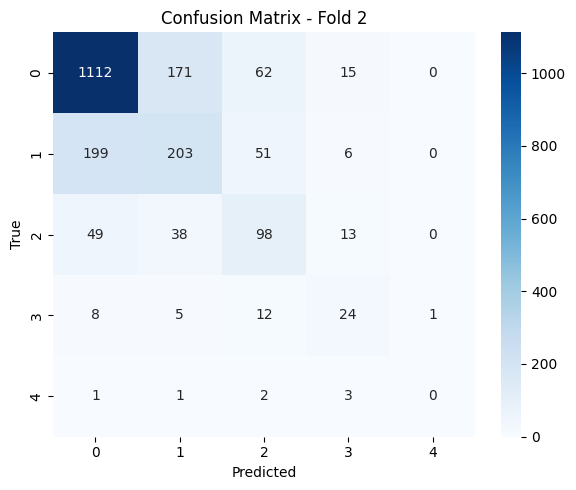

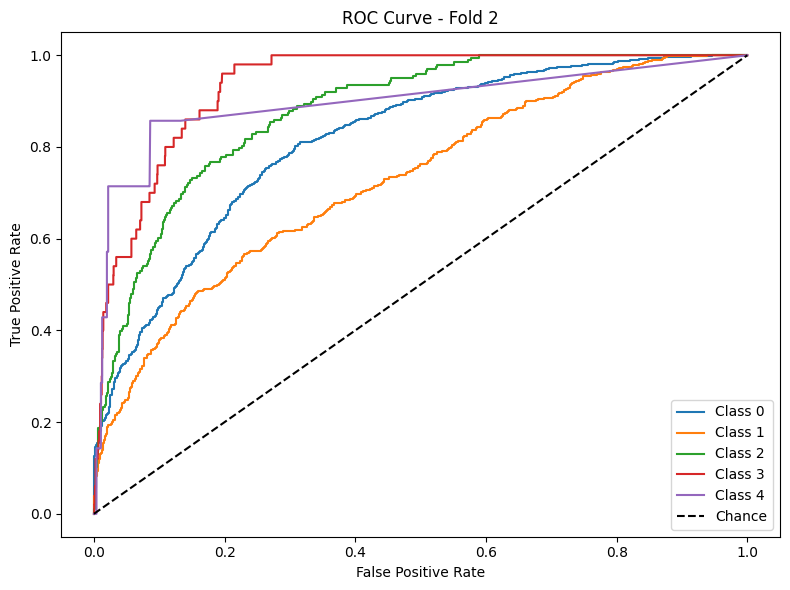


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1360
           1       0.46      0.43      0.45       459
           2       0.38      0.48      0.43       198
           3       0.30      0.44      0.36        50
           4       0.09      0.14      0.11         7

    accuracy                           0.68      2074
   macro avg       0.41      0.46      0.43      2074
weighted avg       0.69      0.68      0.68      2074



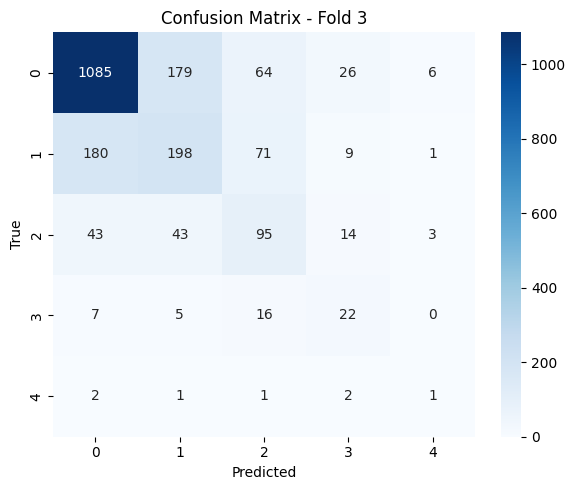

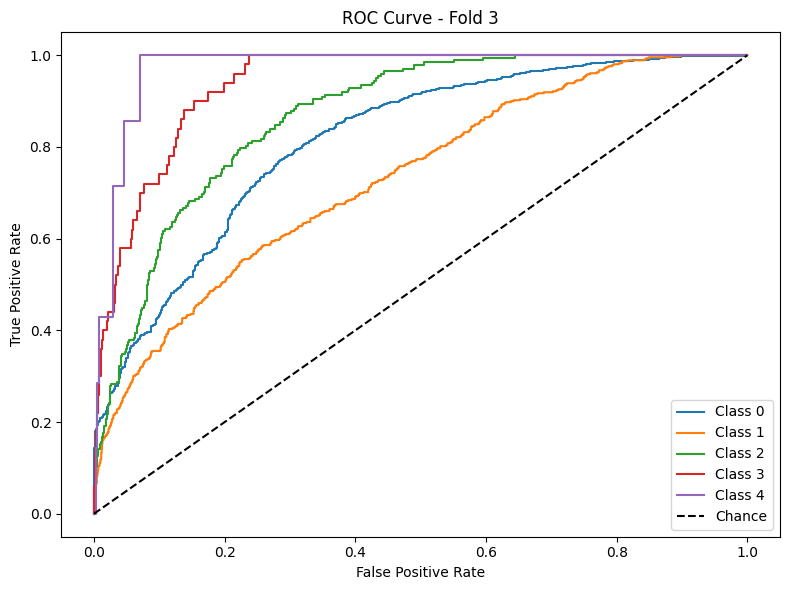


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1360
           1       0.46      0.45      0.45       459
           2       0.41      0.44      0.42       198
           3       0.33      0.38      0.36        50
           4       0.10      0.14      0.12         7

    accuracy                           0.67      2074
   macro avg       0.42      0.44      0.43      2074
weighted avg       0.68      0.67      0.68      2074



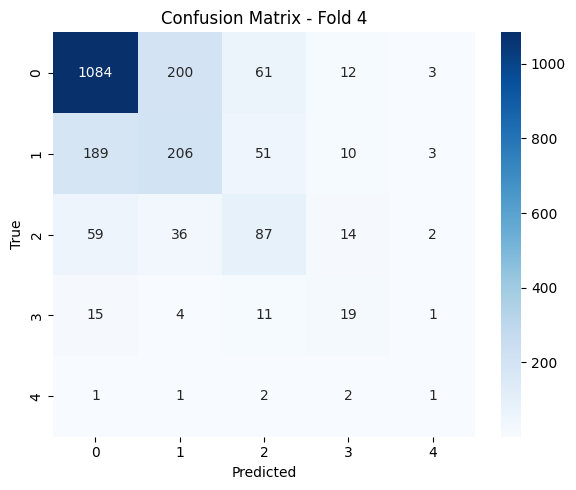

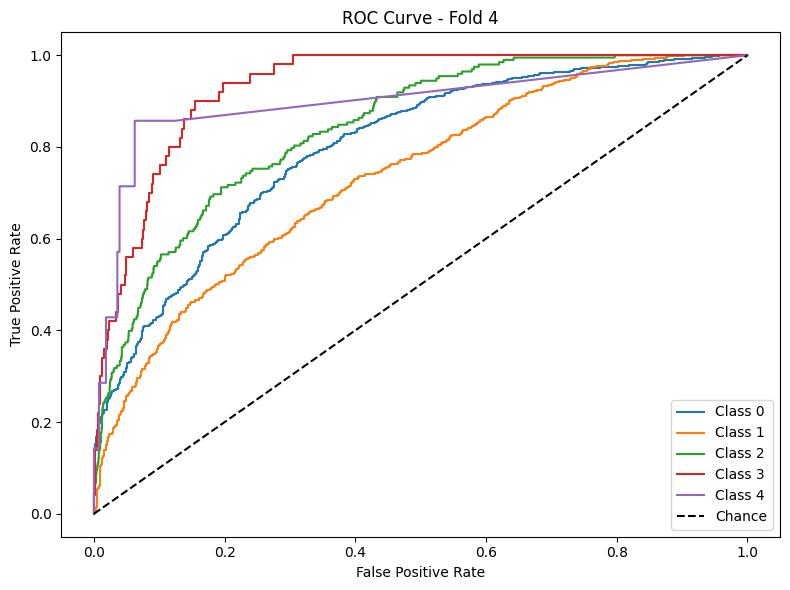


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1360
           1       0.47      0.46      0.46       460
           2       0.39      0.48      0.43       197
           3       0.23      0.29      0.26        49
           4       0.17      0.14      0.15         7

    accuracy                           0.67      2073
   macro avg       0.42      0.43      0.42      2073
weighted avg       0.68      0.67      0.68      2073



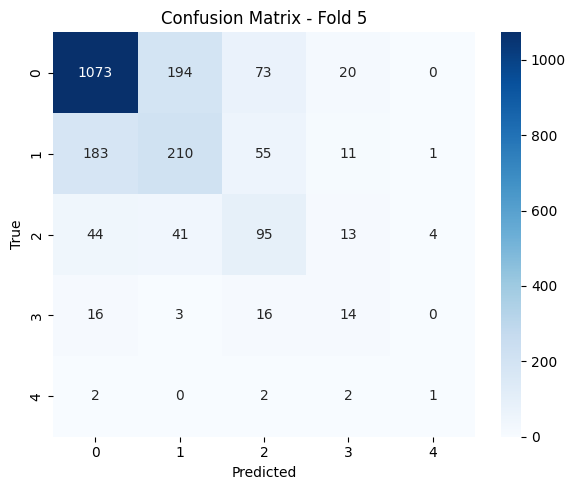

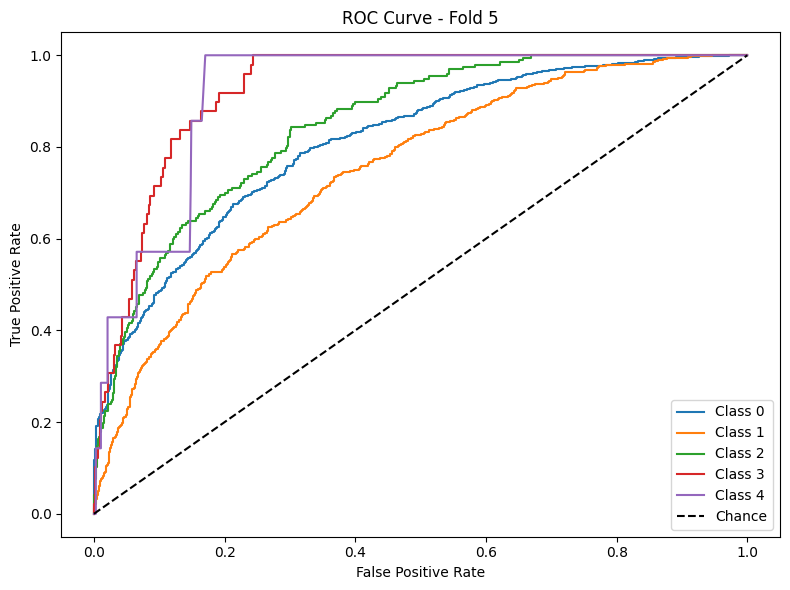


Average Accuracy: 0.6811
Average F1 Macro: 0.4313
Average AUC: 0.8546

Feature Importances:
video                                  0.056962
assignment                             0.054473
combined_emb_3                         0.047188
combined_emb_12                        0.046448
combined_emb_14                        0.042492
combined_emb_11                        0.039359
combined_emb_4                         0.037697
combined_emb_9                         0.036164
combined_emb_8                         0.035441
combined_emb_6                         0.034672
combined_emb_15                        0.034481
combined_emb_13                        0.034133
combined_emb_7                         0.033361
remaining_time                         0.033059
combined_emb_2                         0.031230
combined_emb_1                         0.029975
combined_emb_5                         0.029965
combined_emb_10                        0.029897
combined_emb_0                         0.02

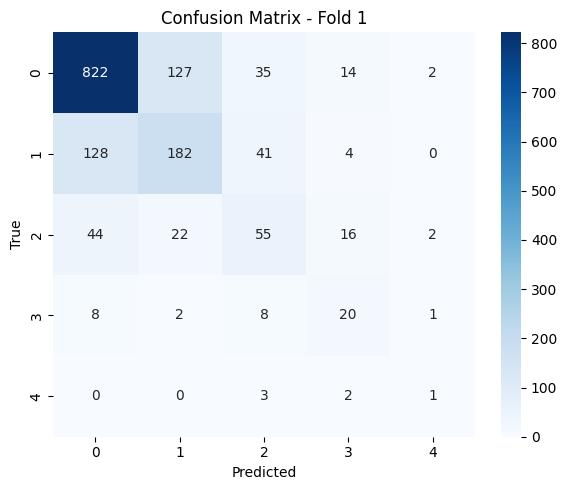

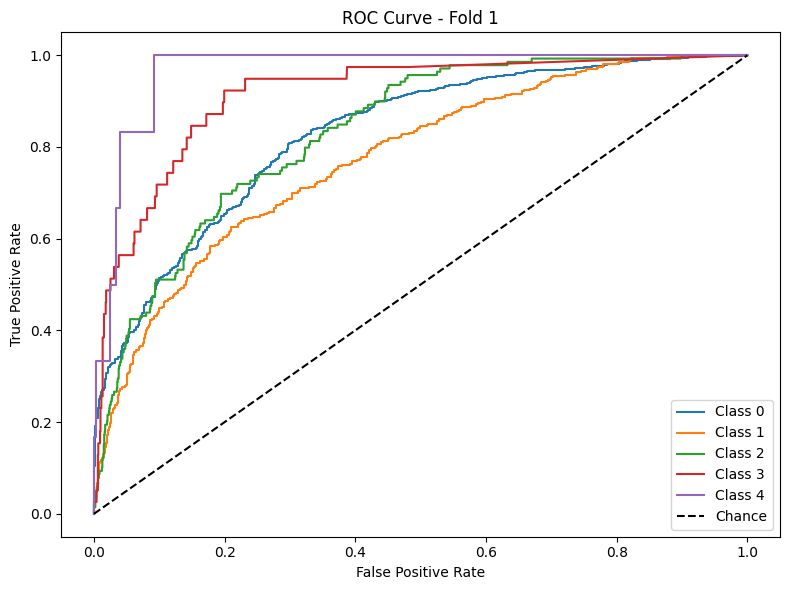


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.52      0.49      0.51       355
           2       0.50      0.50      0.50       139
           3       0.31      0.45      0.37        40
           4       0.11      0.20      0.14         5

    accuracy                           0.70      1539
   macro avg       0.45      0.49      0.47      1539
weighted avg       0.70      0.70      0.70      1539



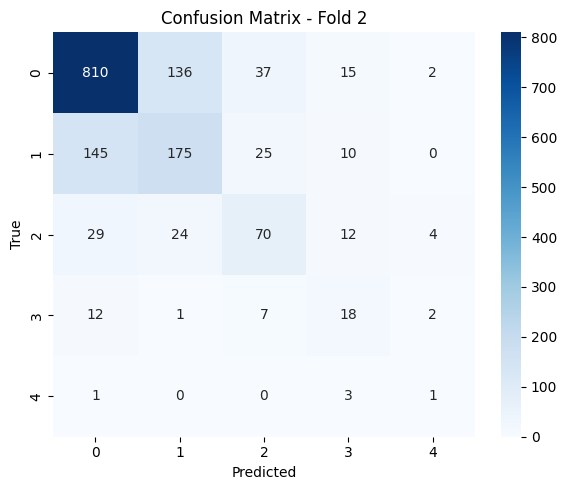

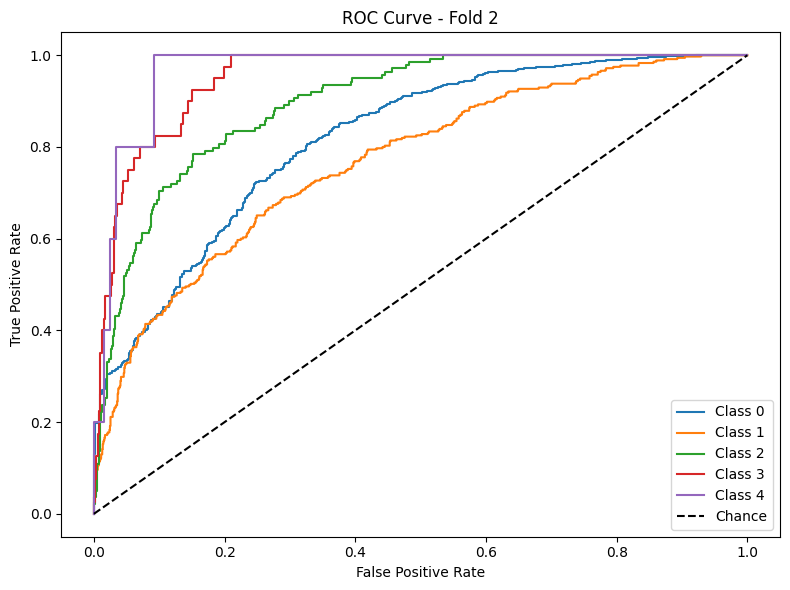


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82       999
           1       0.54      0.54      0.54       355
           2       0.50      0.51      0.51       139
           3       0.31      0.45      0.37        40
           4       0.20      0.17      0.18         6

    accuracy                           0.71      1539
   macro avg       0.48      0.50      0.48      1539
weighted avg       0.72      0.71      0.72      1539



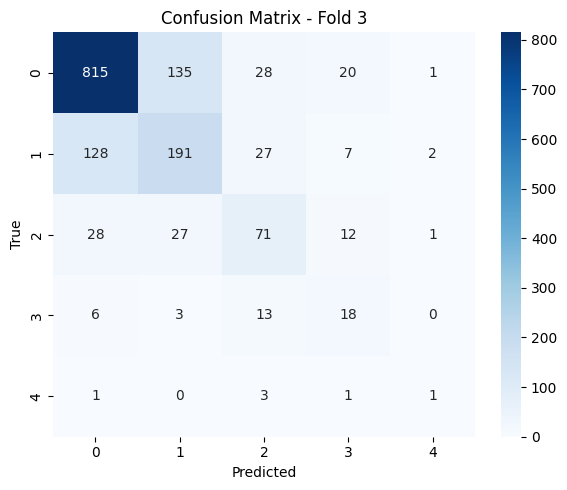

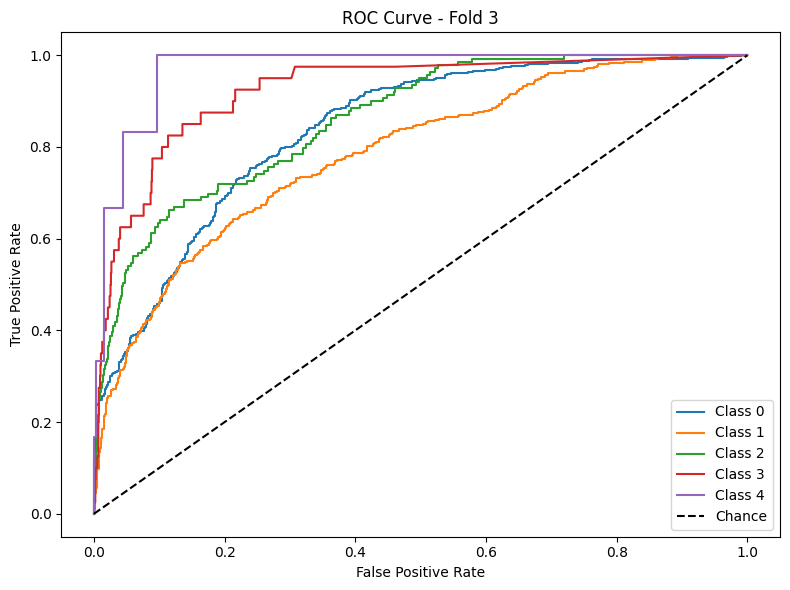


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       999
           1       0.52      0.45      0.48       356
           2       0.43      0.49      0.46       138
           3       0.33      0.38      0.35        39
           4       0.00      0.00      0.00         6

    accuracy                           0.70      1538
   macro avg       0.42      0.43      0.42      1538
weighted avg       0.70      0.70      0.70      1538



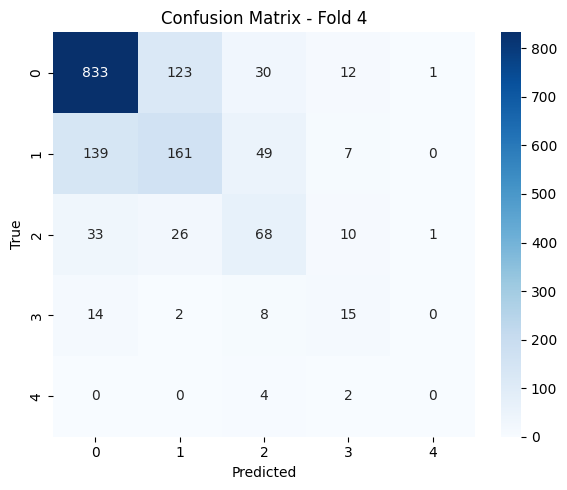

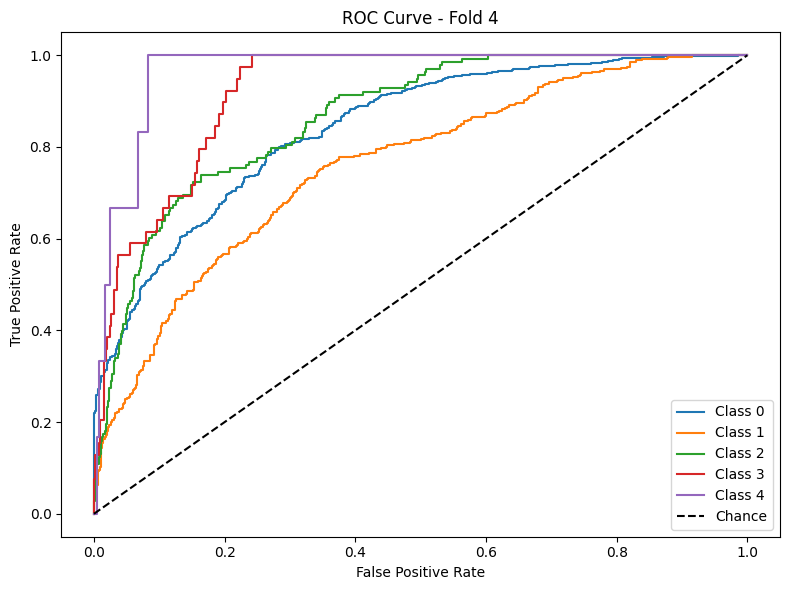


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       999
           1       0.51      0.49      0.50       356
           2       0.36      0.44      0.39       138
           3       0.38      0.49      0.43        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.41      0.45      0.43      1538
weighted avg       0.70      0.69      0.69      1538



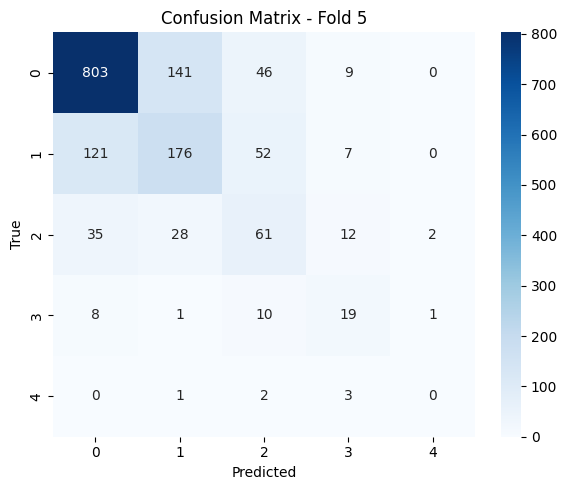

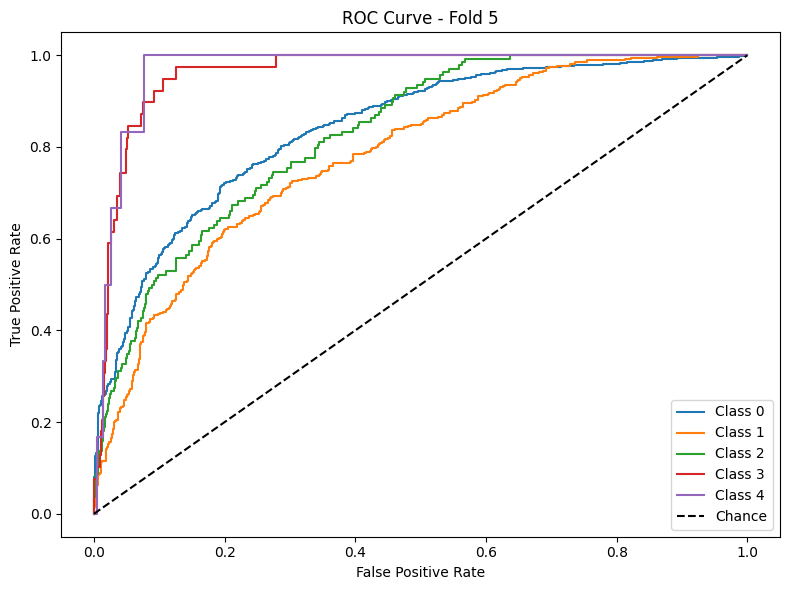


Average Accuracy: 0.7001
Average F1 Macro: 0.4534
Average AUC: 0.8732

Feature Importances:
combined_emb_14                        5.922571e-02
assignment                             5.911510e-02
video                                  4.378620e-02
combined_emb_5                         4.341092e-02
combined_emb_11                        4.128225e-02
combined_emb_1                         3.993154e-02
combined_emb_13                        3.889535e-02
combined_emb_7                         3.536111e-02
combined_emb_15                        3.523675e-02
combined_emb_2                         3.427341e-02
combined_emb_0                         3.153598e-02
combined_emb_9                         3.114665e-02
combined_emb_12                        3.093288e-02
combined_emb_4                         3.056774e-02
user_month                             3.028375e-02
remaining_time                         2.840476e-02
combined_emb_3                         2.743198e-02
school                 

In [8]:
phase_paths = [f"/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       568
           1       0.23      0.24      0.24        63
           2       0.36      0.21      0.26        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.79       698
   macro avg       0.29      0.27      0.28       698
weighted avg       0.75      0.79      0.77       698



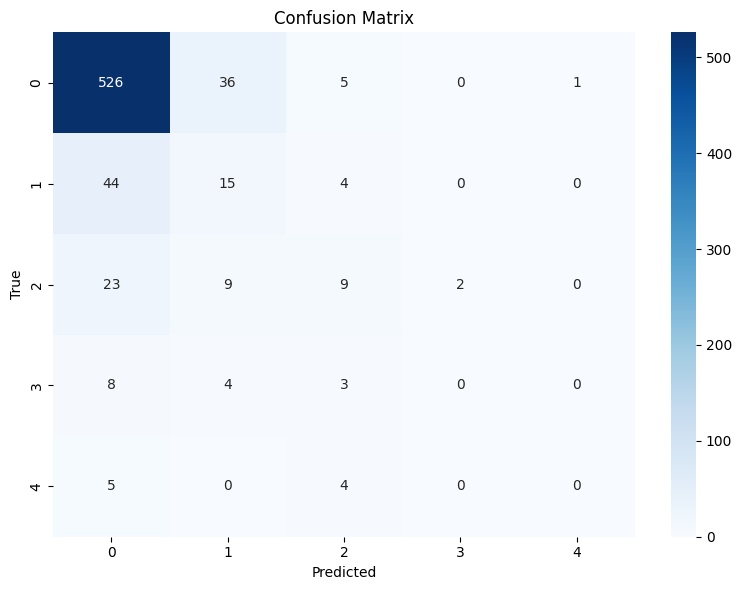


Test AUC (macro-average, OVR): 0.7863


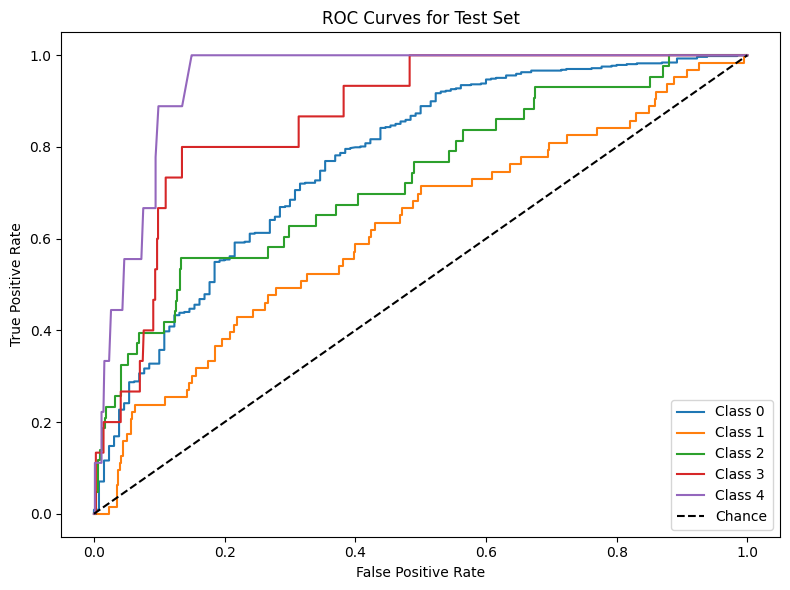

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       544
           1       0.16      0.14      0.15        59
           2       0.28      0.21      0.24        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.77       668
   macro avg       0.26      0.25      0.25       668
weighted avg       0.73      0.77      0.75       668



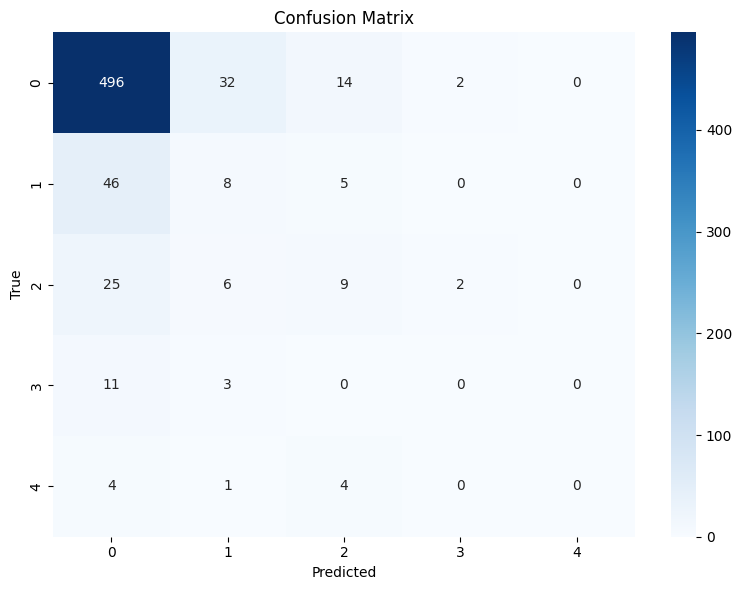


Test AUC (macro-average, OVR): 0.7040


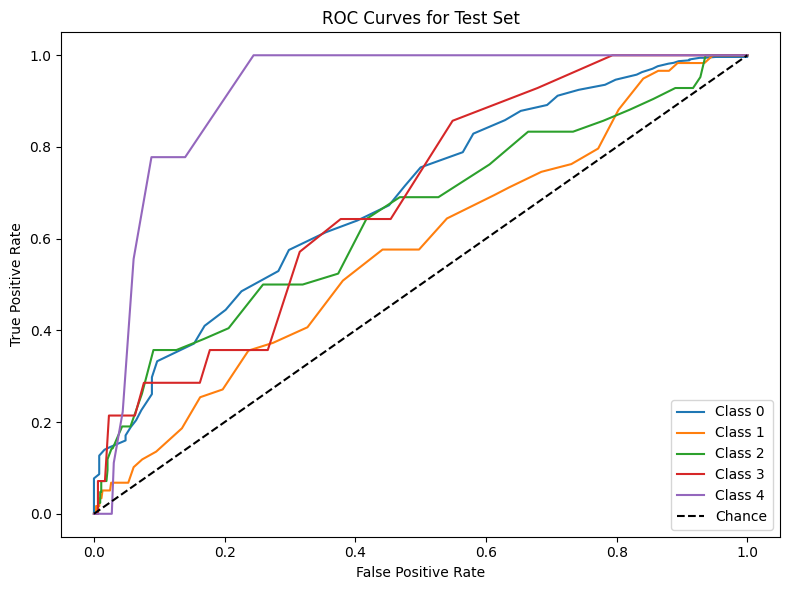

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       455
           1       0.12      0.19      0.15        52
           2       0.05      0.03      0.04        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.70       554
   macro avg       0.20      0.21      0.20       554
weighted avg       0.70      0.70      0.70       554



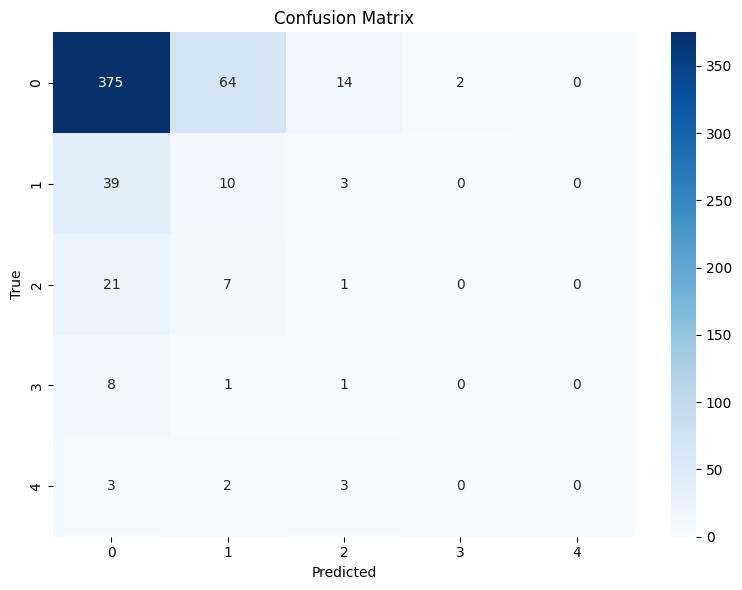


Test AUC (macro-average, OVR): 0.7114


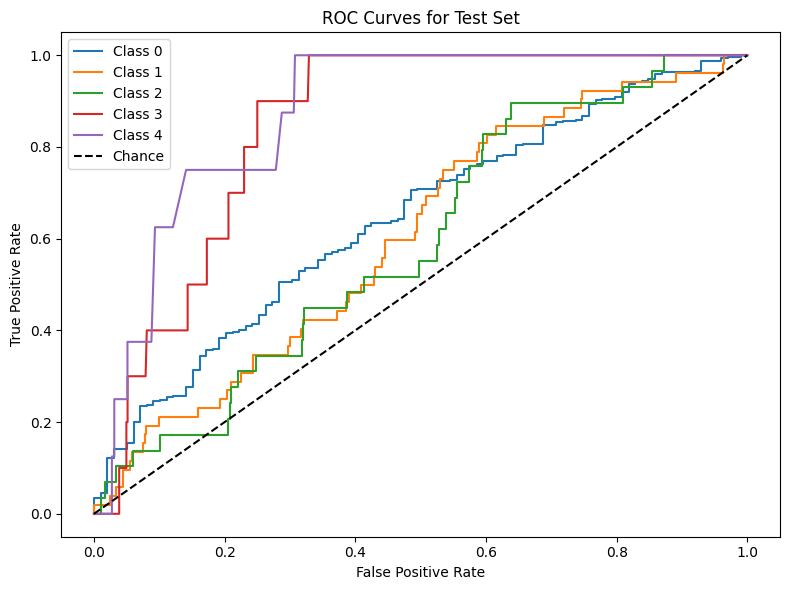

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       395
           1       0.15      0.28      0.20        40
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.72       477
   macro avg       0.20      0.22      0.21       477
weighted avg       0.73      0.72      0.72       477



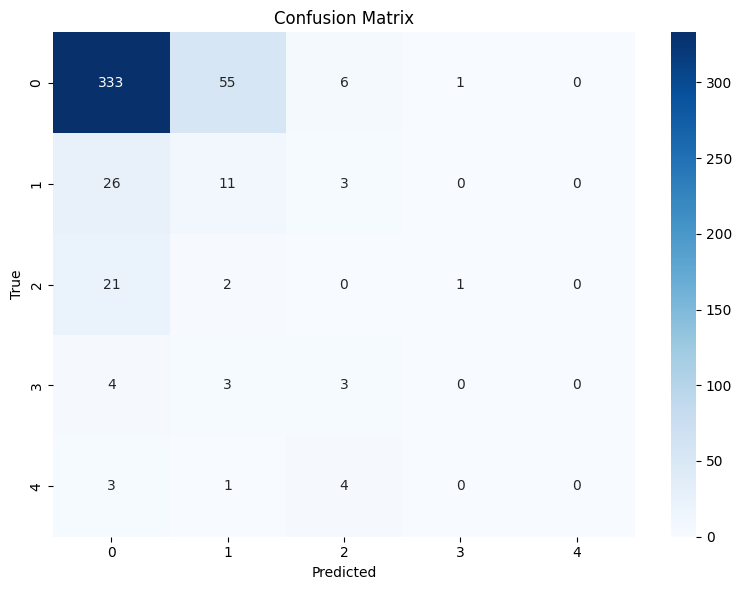


Test AUC (macro-average, OVR): 0.6591


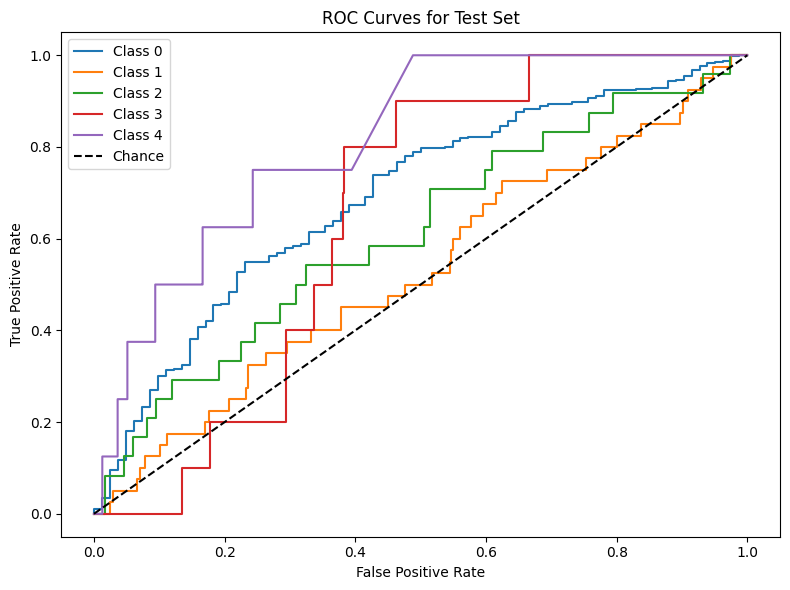

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-using-node2vector/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-enriched-data-with-node2vec/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
